JUAN SEBASTIAN RODRIGUEZ SOLARTE

CESAR AUGUSTO RUIZ PARRA

In [ ]:

from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix
#from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import learning_curve

import pywt
from statsmodels.robust import mad
import cv2

import numpy as np
from numpy.lib.stride_tricks import sliding_window_view
import matplotlib.pyplot as plt
import os

import random
import matplotlib.pyplot as plt
import pandas as pd

#librerias utilizadas
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn.metrics import r2_score
from sklearn.metrics import classification_report,confusion_matrix
import scipy.stats as stats
import tensorflow as tf
from sklearn.neural_network import MLPClassifier #Multi-layer Perceptron classifier
from sklearn.model_selection import train_test_split #Split arrays or matrices into random train and test subsets.
from sklearn.metrics import mean_squared_error #Mean squared error regression loss.
from math import sqrt
from sklearn.metrics import r2_score # (coefficient of determination) regression score function.
from sklearn.metrics import classification_report,confusion_matrix #Build a text report showing the main classification metrics.
from itertools import product
from sklearn.cluster import KMeans

In [ ]:
from google.colab import drive
drive.mount("/content/MyDrive/")

data_frame_final_= pd.read_csv('/content/MyDrive/MyDrive/proyecto3_sennales/df.csv')

Mounted at /content/MyDrive/


In [ ]:
#Se extraen del data set las caracteristicas que se utilizaran para realizar la red neuronal
predictors_ = (list(set(list(data_frame_final_.columns))-set(['Clasificación'])-set(['Posicion'])-set(['Número sujeto'])-set(['Nombre del archivo'])-set(['Raw signals'])-set(['Unnamed: 0'])-set(['Unnamed: 0.1'])-set(['genero'])-set(['edad'])-set(['Mediana'])))
print(predictors_)
#Se crea un data_frame que solo contenga los sujetos sanos y los sujetos con sibilancias
#sujetos con sibilancias
sibilancia = data_frame_final_.loc[:, 'Clasificación'] == 'Sibilancia'
df_sibilancias = data_frame_final_.loc[sibilancia]
#Sujetos sanos
sanos = data_frame_final_.loc[:, 'Clasificación'] == 'Sanos'
df_sanos = data_frame_final_.loc[sanos]

#Se concatenan los data frame de los sujetos sanos y los sujetos con sibilancia; es de resaltar que debido al desbalanceo de datos
# se establece un limite en la longitud de los datos de sujetos sanos, con el fin de que ambos grupos a analizar presenten una cantidad de datos
#que no sea tan diferentes entre si
# Ordena el DataFrame por la columna "Edades" de menor a mayor
df_edades_ordenadas = df_sanos.sort_values(by="edad")
y=pd.concat([df_edades_ordenadas[100:600],df_edades_ordenadas[2000:2500]])

sibilancias_final = pd.concat([df_sibilancias,y])
# longitud de los data_frame
print(len(df_sibilancias))
print(len(df_sanos))
sibilancias_final

['Varianza', 'ADPE', 'DPE']
886
3642


,Unnamed: 0.1,Unnamed: 0,Número sujeto,Nombre del archivo,Posicion,Clasificación,Raw signals,Varianza,Mediana,DPE,ADPE,edad,genero
36,36,36,103,103_2b2_Ar_mc_LittC2SE,Ar,Sibilancia,[0.04949643 0.04953381 0.04951206 ... 0.051487...,0.007053,3.804086e-11,5.943951e-10,9.153685e-08,0.75,F
38,38,38,103,103_2b2_Ar_mc_LittC2SE,Ar,Sibilancia,[0.17231599 0.17262137 0.17295634 ... 0.029716...,0.007408,3.804086e-11,3.586638e-10,5.523423e-08,0.75,F
39,39,39,103,103_2b2_Ar_mc_LittC2SE,Ar,Sibilancia,[ 0.02938355 0.02940707 0.02950936 ... -0.02...,0.008711,3.804086e-11,4.515803e-10,6.954336e-08,0.75,F
40,40,40,103,103_2b2_Ar_mc_LittC2SE,Ar,Sibilancia,[-0.02477263 -0.02439712 -0.02400584 ... -0.18...,0.008095,3.804086e-11,4.428955e-10,6.820590e-08,0.75,F
48,48,48,104,104_1b1_Ar_sc_Litt3200,Ar,Sibilancia,[0.00075901 0.00082952 0.00088433 ... 0.010851...,0.000143,3.804086e-11,1.304930e-09,2.009592e-07,70.00,F
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3607,3607,3607,163,163_8b3_Ll_mc_AKGC417L,Ll,Sanos,[-0.03309419 -0.03428029 -0.03546589 ... -0.10...,0.000667,3.804086e-11,2.668791e-09,4.109938e-07,67.00,F
3608,3608,3608,163,163_8b3_Ll_mc_AKGC417L,Ll,Sanos,[-0.1026367 -0.10331608 -0.10394442 ... -0.01...,0.000798,3.804086e-11,3.455400e-09,5.321317e-07,67.00,F
3609,3609,3609,163,163_8b3_Ll_mc_AKGC417L,Ll,Sanos,[-0.01577472 -0.01568398 -0.01563412 ... -0.02...,0.000720,3.804086e-11,4.622081e-09,7.118005e-07,67.00,F
3610,3610,3610,163,163_8b3_Ll_mc_AKGC417L,Ll,Sanos,[-2.99421055e-02 -3.00105682e-02 -3.01133384e-...,0.000673,3.804086e-11,4.990322e-09,7.685095e-07,67.00,F


In [ ]:
#Datos de entrenamiento y datos de test
#Se normalizan los datos
sibilancias_final[predictors_] = sibilancias_final[predictors_]/sibilancias_final[predictors_].max()

# Se establecen las caracteristicas y la salida del modelo
X = sibilancias_final[predictors_].values
y = sibilancias_final['Clasificación'].values

#Se distribuyen los datos,, tomando un 30% para prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=40)
y_test = np.squeeze(y_test)
y_train = np.squeeze(y_train)

#Se muestra el tamaño de los datos
print(f' Tamaño de las caracteristicas los datos de entrenamiento: {X_train.shape}')
print(f' Tamaño de la salida de los datos de entrenamiento: {y_train.shape}')

print(f' Tamaño de las caracteristicas los datos de prueba: {X_test.shape}')
print(f' Tamaño de la salida de los datos de prueba: {y_test.shape}')

 Tamaño de las caracteristicas los datos de entrenamiento: (1320, 3)
 Tamaño de la salida de los datos de entrenamiento: (1320,)
 Tamaño de las caracteristicas los datos de prueba: (566, 3)
 Tamaño de la salida de los datos de prueba: (566,)


In [ ]:
#Función para la matriz de confusion
from itertools import product
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    Esta función muestra y grafica la matriz de confusión.
    """
    #Matriz de confusión normalizada
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    #Grafico de la matriz de confusión
    print(cm)
    fig=plt.figure()
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    #Caracteristicas para graficar la matriz de confusión
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [ ]:
#Curva de aprendizaje
def plot_learning_curve(
    estimator,
    title,
    X,
    y,
    axes=None,
    ylim=None,
    cv=None,
    n_jobs=None,
    scoring=None,
    train_sizes=np.linspace(0.1, 1.0, 5),
):
    """
    Genera 3 graficas: La curva de prueba y la curva de aprendizaje, los datos
    de entrenamiento vs la curva de tiempos de ajuste, la curva de tiempos de
    ajuste frente a la puntuación.

    Parameters
    ----------
    estimator : instancia de estimador. Una instancia de estimador que implementa los métodos `fit` y `predict`
    que se clonará para cada validación.

    title : str

    X : array-like de tamaño (n_samples, n_features)
        vector de entrenamiento, donde``n_samples``es el numero de muestras y ``n_features`` es
        el número de caracteristicas.

    y : array-like de tamaño (n_samples) o (n_samples, n_features)
        Objetivo relativo a ``X`` para la clasificación o la regresión;

    axes : array-like de tamañoe (3,), default=None
        Se implementa para la grafica de la curva.

    ylim : tuple de tamaño (2,), default=None

    cv : int, generador de validación cruzada o un iterable, por defecto=None
        Determina la estrategia de división de la validación cruzada.
        Las entradas posibles para cv son:

          - None, para utilizar la validación cruzada de 5 pliegues por defecto,
          - Entero, para especificar el número de pliegues.
          - Un iterable que produce divisiones (tren, prueba) como matrices de índices.

    n_jobs : int o None, por defecto=None
        Número de trabajos a ejecutar en paralelo.

    scoring : str or callable, default=None

    train_sizes : tipo array de forma (n_ticks,)
        Números relativos o absolutos de muestras de entrenamiento que se utilizarán para
        generar la curva de aprendizaje. Si el ``dtype`` es float, se considera
        como una fracción del tamaño máximo del conjunto de entrenamiento (que es
        (determinado por el método de validación seleccionado), es decir, tiene que estar dentro de
        (0, 1]. En caso contrario, se interpreta como el tamaño absoluto de los conjuntos de
        de los conjuntos de entrenamiento. Tenga en cuenta que, para la clasificación, el número de muestras
        suele ser lo suficientemente grande como para contener al menos una muestra de cada clase.
        (por defecto: np.linspace(0.1, 1.0, 5))
    """
    #Se estable los axes
    if axes is None:
        _, axes = plt.subplots(1, figsize=(10, 10))


    axes.set_title(title)
    #Se establece y lim
    if ylim is not None:
        axes.set_ylim(*ylim)
    axes.set_xlabel("Training examples")
    axes.set_ylabel("Score")

    #Se genera la curva de aprendizaje
    train_sizes, train_scores, test_scores, fit_times, _ = learning_curve(
        estimator,
        X,
        y,
        scoring=scoring,
        cv=cv,
        n_jobs=n_jobs,
        train_sizes=train_sizes,
        return_times=True,
    )
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)

    # Grafico de la curva de aprendizaje
    axes.grid()
    axes.fill_between(
        train_sizes,
        train_scores_mean - train_scores_std,
        train_scores_mean + train_scores_std,
        alpha=0.1,
        color="r",
    )
    axes.fill_between(
        train_sizes,
        test_scores_mean - test_scores_std,
        test_scores_mean + test_scores_std,
        alpha=0.1,
        color="g",
    )
    axes.plot(
        train_sizes, train_scores_mean, "o-", color="r", label="Training score"
    )
    axes.plot(
        train_sizes, test_scores_mean, "o-", color="g", label="Cross-validation score"
    )
    axes.legend(loc="best")

    #Se retorna el grafico de la curva de aprendizaje
    return plt

In [ ]:

'''
  MLPClassifier es una clase de sklearn que permite crear una red neuronal, la
  cual tiene como argumentos:

  - hidden_layer_sizes: Con este parámetro podemos especificar el número de capas
  y el número de nodos que queremos tener en el Clasificador de Redes Neuronales.
  Cada elemento de la tupla representa el número de nodos en la i-ésima posición,
  donde i es el índice de la tupla. Así, la longitud de la tupla indica el
  número total de capas ocultas en la red neuronal.
  - activation: es la funcion de activacion de la capa oculta.
  - solver: es el solucionador para la optimización del peso sobre los nodos.
  - max_iter: es el numero máximo de iteraciones (número de epocas).
'''

#Se genera el modelo. En este caso se implementan 3 capas ocultas, las cuales tienen 4 neuronas
mlp_sib = MLPClassifier(hidden_layer_sizes=(20,20,20), activation='relu', solver='adam',learning_rate='adaptive',random_state=1, early_stopping=True, max_iter=10000)
print(mlp_sib)

MLPClassifier(early_stopping=True, hidden_layer_sizes=(20, 20, 20),
              learning_rate='adaptive', max_iter=10000, random_state=1)


In [ ]:
#Se entrena el modelo y se realizan las predicciones
mlp_sib.fit(X_train,y_train)

predict_train = mlp_sib.predict(X_train)
predict_test = mlp_sib.predict(X_test)

In [ ]:
#Metricas
target_names = ['Sanos', 'Sibilancias']
print(classification_report(y_train,predict_train,target_names=target_names))
print(classification_report(y_test,predict_test,target_names=target_names))

              precision    recall  f1-score   support

       Sanos       0.54      0.94      0.69       696
 Sibilancias       0.66      0.12      0.20       624

    accuracy                           0.55      1320
   macro avg       0.60      0.53      0.45      1320
weighted avg       0.60      0.55      0.46      1320

              precision    recall  f1-score   support

       Sanos       0.56      0.98      0.71       304
 Sibilancias       0.81      0.11      0.20       262

    accuracy                           0.58       566
   macro avg       0.69      0.55      0.46       566
weighted avg       0.68      0.58      0.48       566



Confusion matrix, without normalization
[[297   7]
 [232  30]]


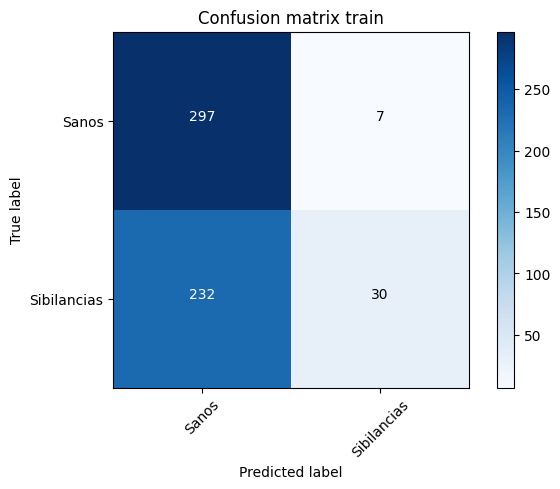

In [ ]:

#Matriz de confusión sujetos de prueba
mc_test = confusion_matrix(y_test,predict_test)
plot_confusion_matrix(mc_test, classes=target_names,
                      title='Confusion matrix train')

Confusion matrix, without normalization
[[657  39]
 [549  75]]


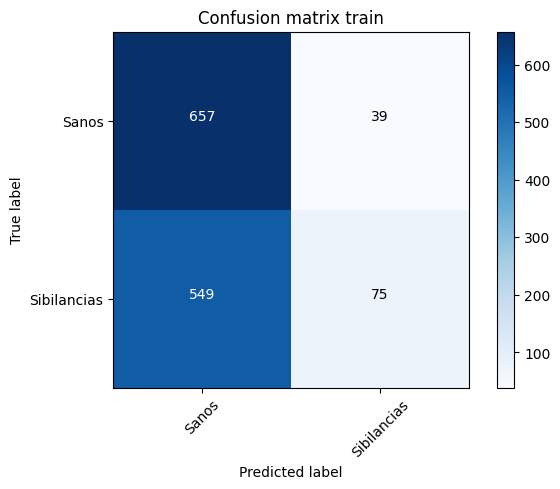

In [ ]:
#Matriz de confusión sujetos de entrenamiento
mc_train = confusion_matrix(y_train,predict_train)
plot_confusion_matrix(mc_train, classes=target_names,
                      title='Confusion matrix train')

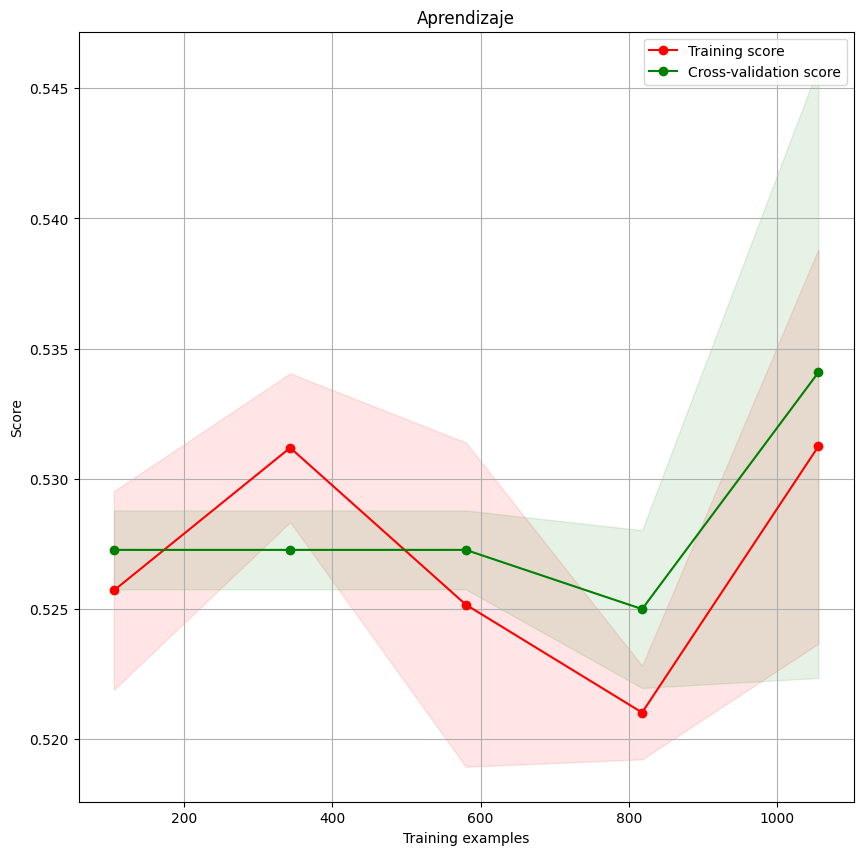

In [ ]:

#Se genera la curva de aprendizaje
plot_learning_curve(estimator=mlp_sib,
                    X=X_train,
                    y=y_train,
                    title='Aprendizaje')
plt.show()


              precision    recall  f1-score   support

       Sanos       0.56      0.98      0.71       304
  Sibilancia       0.77      0.09      0.16       262

    accuracy                           0.57       566
   macro avg       0.66      0.53      0.44       566
weighted avg       0.66      0.57      0.46       566

Confusion matrix, without normalization
[[297   7]
 [238  24]]


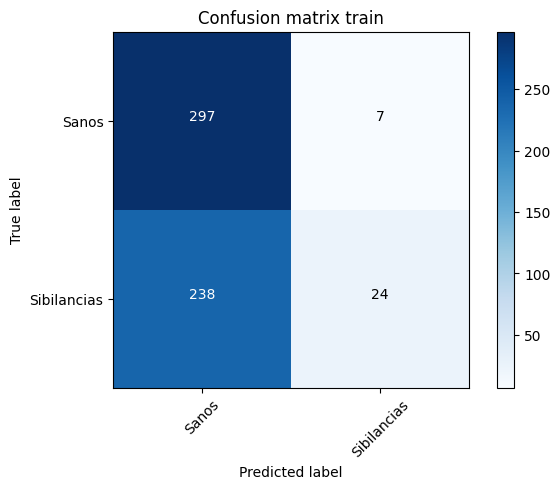

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

       Sanos       0.54      1.00      0.70       304
  Sibilancia       0.00      0.00      0.00       262

    accuracy                           0.54       566
   macro avg       0.27      0.50      0.35       566
weighted avg       0.29      0.54      0.38       566

Confusion matrix, without normalization
[[304   0]
 [262   0]]


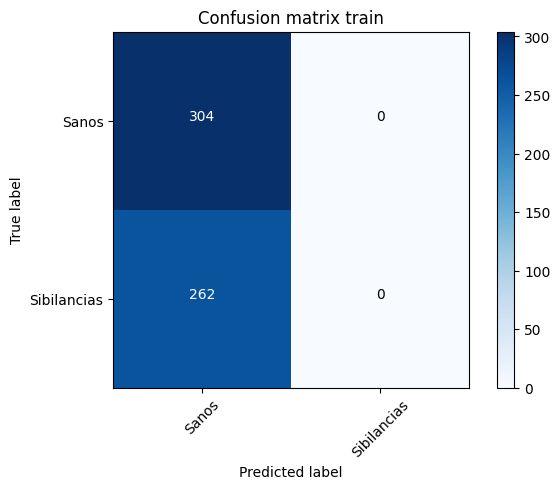

              precision    recall  f1-score   support

       Sanos       0.55      0.99      0.70       304
  Sibilancia       0.83      0.04      0.07       262

    accuracy                           0.55       566
   macro avg       0.69      0.52      0.39       566
weighted avg       0.68      0.55      0.41       566

Confusion matrix, without normalization
[[302   2]
 [252  10]]


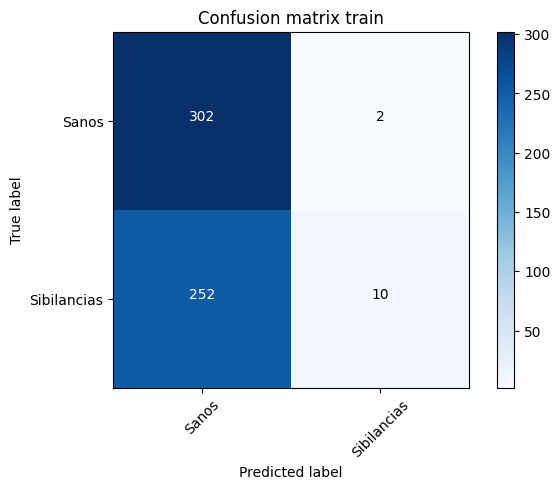

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

       Sanos       0.54      1.00      0.70       304
  Sibilancia       0.00      0.00      0.00       262

    accuracy                           0.54       566
   macro avg       0.27      0.50      0.35       566
weighted avg       0.29      0.54      0.38       566

Confusion matrix, without normalization
[[304   0]
 [262   0]]


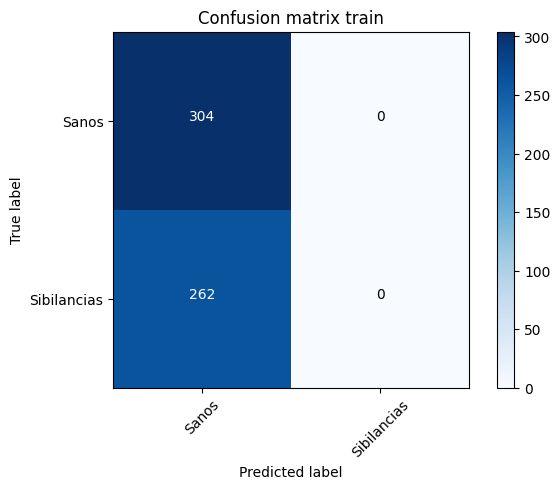

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

       Sanos       0.54      1.00      0.70       304
  Sibilancia       0.00      0.00      0.00       262

    accuracy                           0.54       566
   macro avg       0.27      0.50      0.35       566
weighted avg       0.29      0.54      0.38       566

Confusion matrix, without normalization
[[304   0]
 [262   0]]


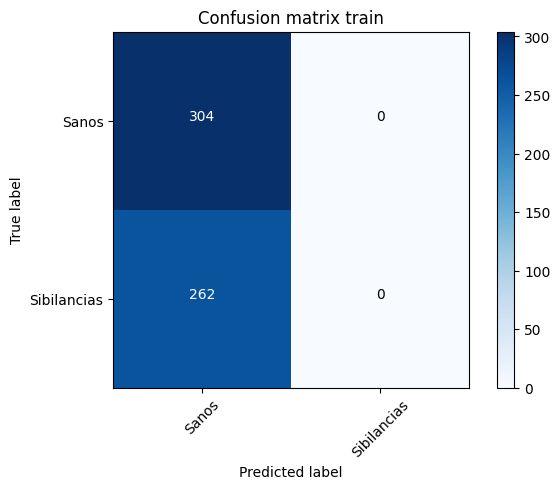

El promedio en validación es de 0.273


In [ ]:
# Proceso de k-folds
k_folds = KFold(5, random_state=1, shuffle = True)

scores_valid = np.zeros(10)

for pos, (train, test) in enumerate(k_folds.split( X_train, y_train)):
  #Se entrenan los datos y se establece el Y predicho
  mlp_sib.fit(X_train[train], y_train[train])
  y_pred =  mlp_sib.predict(X_test)

  #Se establecen las metricas
  print(classification_report(y_test, y_pred))
  scores_valid[pos] =  mlp_sib.score(X_test,y_test)
  #Se grafica la matriz de confusión
  mc_test = confusion_matrix(y_test,y_pred)
  plot_confusion_matrix(mc_test, classes=target_names,
                      title='Confusion matrix train')
  plt.show()

print(f'El promedio en validación es de {round(scores_valid.mean(),4)}')

Segunda arquitectura

In [ ]:
clf_2 = MLPClassifier((100,100,100,100), #Tamaño de la red
                      max_iter=10000, #Número de iteraciones
                      activation='relu', # Función de activación
                      solver='adam', # optimizador de función de perdida
                      learning_rate='adaptive', # Cambios en la tasa de aprendizaje
                      random_state=1,
                      early_stopping=True) #Evitar sobre entrenamiento en la convergencia del optimizador

In [ ]:
#Entrenamiento del modelo y predicciones
clf_2.fit(X_train, y_train)

predict_train_2 = clf_2.predict(X_train)
predict_test_2 = clf_2.predict(X_test)

In [ ]:
#Metricas
target_names = ['Sanos', 'Sibilancias']
print(classification_report(y_train,predict_train_2,target_names=target_names))
print(classification_report(y_test,predict_test_2,target_names=target_names))

              precision    recall  f1-score   support

       Sanos       0.54      0.94      0.69       696
 Sibilancias       0.64      0.13      0.21       624

    accuracy                           0.55      1320
   macro avg       0.59      0.53      0.45      1320
weighted avg       0.59      0.55      0.46      1320

              precision    recall  f1-score   support

       Sanos       0.56      0.96      0.71       304
 Sibilancias       0.76      0.13      0.22       262

    accuracy                           0.58       566
   macro avg       0.66      0.55      0.47       566
weighted avg       0.65      0.58      0.48       566



Confusion matrix, without normalization
[[293  11]
 [228  34]]


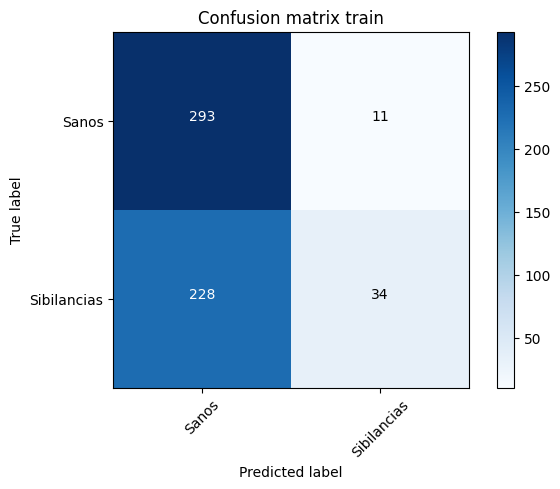

In [ ]:
#Matriz de confusión sujetos de prueba
mc_test_2 = confusion_matrix(y_test,predict_test_2)
plot_confusion_matrix(mc_test_2, classes=target_names,
                      title='Confusion matrix train')

Confusion matrix, without normalization
[[652  44]
 [545  79]]


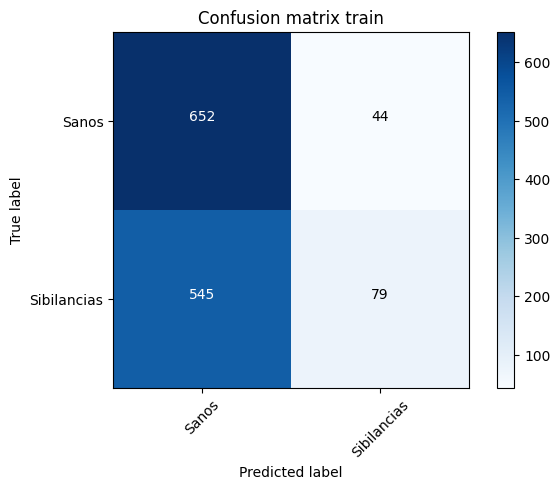

In [ ]:
#Matriz de confusión sujetos de entrenamiento
mc_train_2 = confusion_matrix(y_train,predict_train_2)
plot_confusion_matrix(mc_train_2, classes=target_names,
                      title='Confusion matrix train')

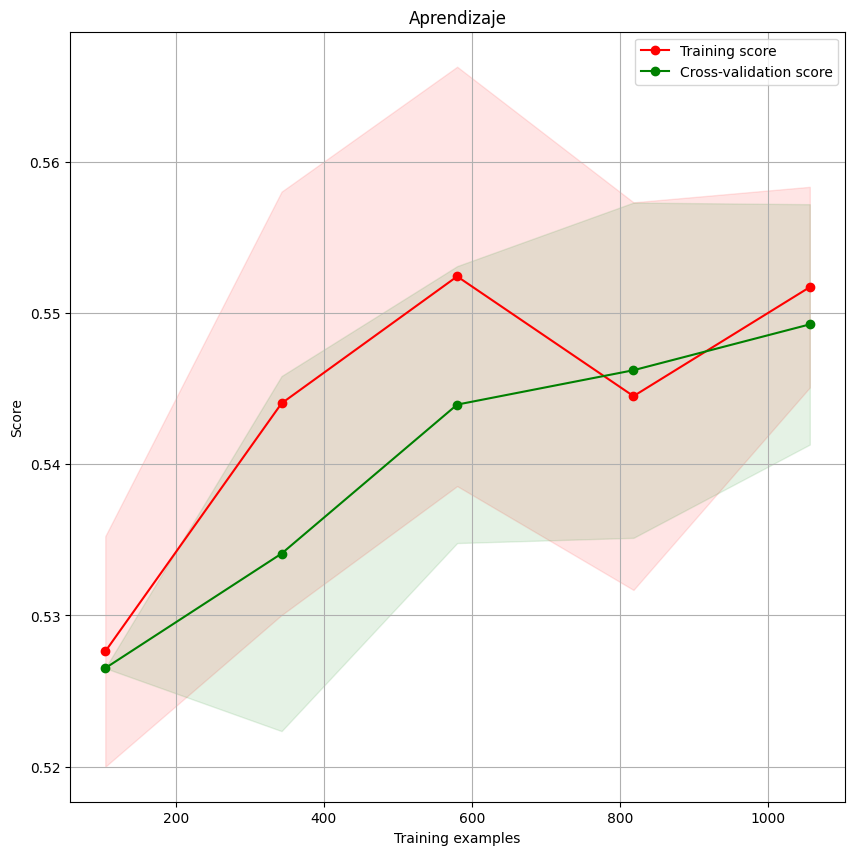

In [ ]:
#Curva de aprendizaje
plot_learning_curve(estimator=clf_2,
                    X=X_train,
                    y=y_train,
                    title='Aprendizaje')
plt.show()

              precision    recall  f1-score   support

       Sanos       0.56      0.96      0.71       304
  Sibilancia       0.75      0.13      0.22       262

    accuracy                           0.58       566
   macro avg       0.66      0.54      0.46       566
weighted avg       0.65      0.58      0.48       566

Confusion matrix, without normalization
[[293  11]
 [229  33]]


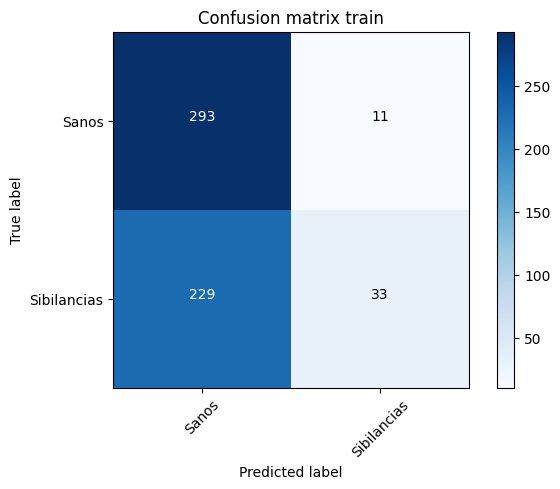

              precision    recall  f1-score   support

       Sanos       0.55      0.98      0.70       304
  Sibilancia       0.74      0.06      0.12       262

    accuracy                           0.56       566
   macro avg       0.64      0.52      0.41       566
weighted avg       0.64      0.56      0.43       566

Confusion matrix, without normalization
[[298   6]
 [245  17]]


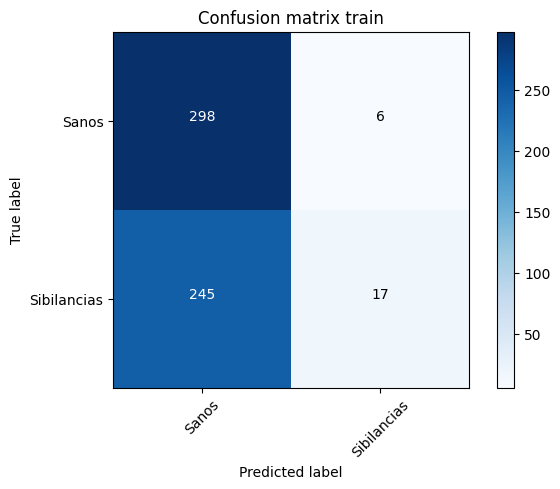

              precision    recall  f1-score   support

       Sanos       0.56      0.98      0.71       304
  Sibilancia       0.80      0.11      0.19       262

    accuracy                           0.57       566
   macro avg       0.68      0.54      0.45       566
weighted avg       0.67      0.57      0.47       566

Confusion matrix, without normalization
[[297   7]
 [234  28]]


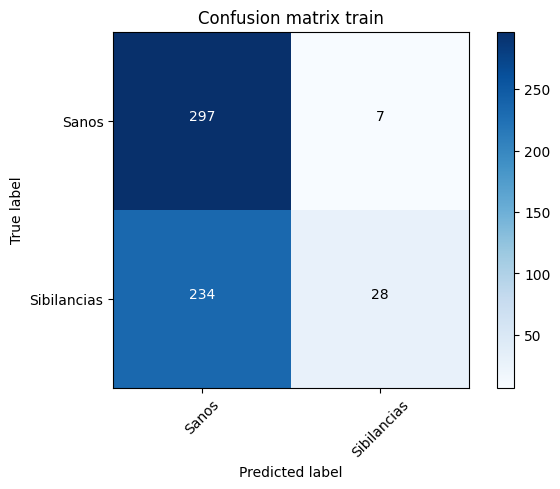

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

       Sanos       0.54      1.00      0.70       304
  Sibilancia       0.00      0.00      0.00       262

    accuracy                           0.54       566
   macro avg       0.27      0.50      0.35       566
weighted avg       0.29      0.54      0.38       566

Confusion matrix, without normalization
[[304   0]
 [262   0]]


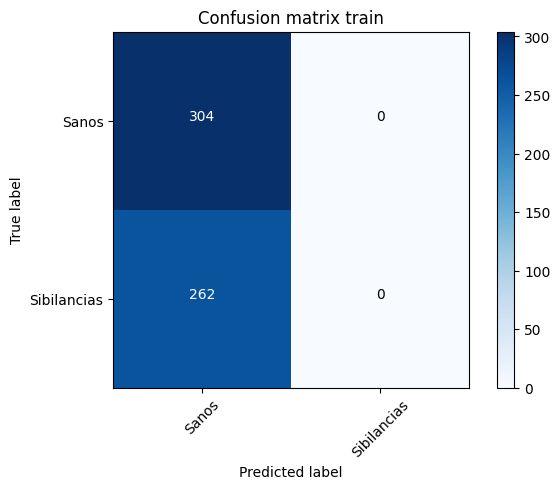

              precision    recall  f1-score   support

       Sanos       0.56      0.96      0.71       304
  Sibilancia       0.73      0.14      0.23       262

    accuracy                           0.58       566
   macro avg       0.65      0.55      0.47       566
weighted avg       0.64      0.58      0.49       566

Confusion matrix, without normalization
[[291  13]
 [226  36]]


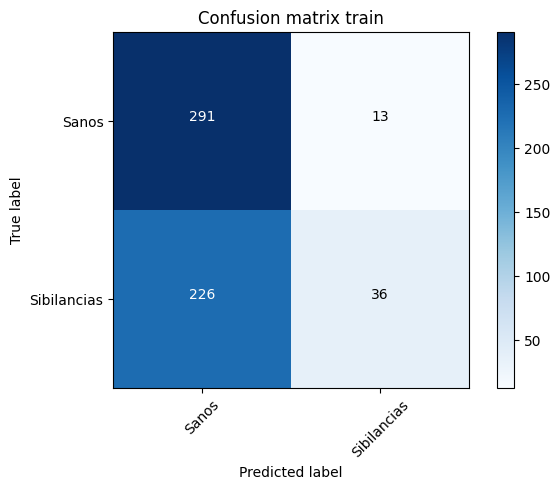

El promedio en validación es de 0.2822


In [ ]:
# Proceso de k-folds
k_folds = KFold(5, random_state=1, shuffle = True)

scores_valid = np.zeros(10)

for pos, (train, test) in enumerate(k_folds.split(X_train, y_train)):

  clf_2.fit(X_train[train], y_train[train])
  y_pred = clf_2.predict(X_test)
  #Se establecen las metricas
  print(classification_report(y_test, y_pred))
  scores_valid[pos] = clf_2.score(X_test,y_test)
  #Se grafica la matriz de confusión
  mc_test = confusion_matrix(y_test,y_pred)
  plot_confusion_matrix(mc_test, classes=target_names,
                      title='Confusion matrix train')
  plt.show()

print(f'El promedio en validación es de {round(scores_valid.mean(),4)}')

Tercera arquitectura

In [ ]:
clf_3 = MLPClassifier((100,100,100,100,100,100), #Tamaño de la red
                      max_iter=1000, #Número de iteraciones
                      activation='relu', # Función de activación
                      solver='sgd', # optimizador de función de perdida
                      learning_rate='adaptive', # Cambios en la tasa de aprendizaje
                      random_state=1,
                      early_stopping=True) #Evitar sobre entrenamiento en la convergencia del optimizador

In [ ]:
#Entrenamiento del modelo y predicciones
clf_3.fit(X_train, y_train)

predict_train_3 = clf_3.predict(X_train)
predict_test_3 = clf_3.predict(X_test)

In [ ]:
#Metricas
target_names = ['Sanos', 'Sibilancias']
print(classification_report(y_train,predict_train_3,target_names=target_names))
print(classification_report(y_test,predict_test_3,target_names=target_names))

              precision    recall  f1-score   support

       Sanos       0.53      1.00      0.69       696
 Sibilancias       0.00      0.00      0.00       624

    accuracy                           0.53      1320
   macro avg       0.26      0.50      0.35      1320
weighted avg       0.28      0.53      0.36      1320

              precision    recall  f1-score   support

       Sanos       0.54      1.00      0.70       304
 Sibilancias       0.00      0.00      0.00       262

    accuracy                           0.54       566
   macro avg       0.27      0.50      0.35       566
weighted avg       0.29      0.54      0.38       566



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif

Confusion matrix, without normalization
[[304   0]
 [262   0]]


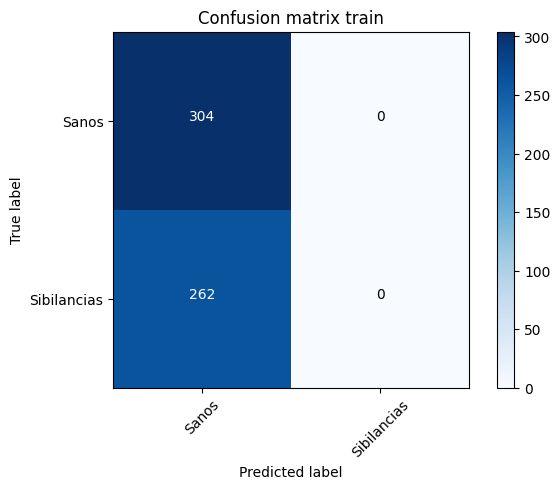

In [ ]:
#Matriz de confusión sujetos de prueba
mc_test_3 = confusion_matrix(y_test,predict_test_3)
plot_confusion_matrix(mc_test_3, classes=target_names,
                      title='Confusion matrix train')

Confusion matrix, without normalization
[[696   0]
 [624   0]]


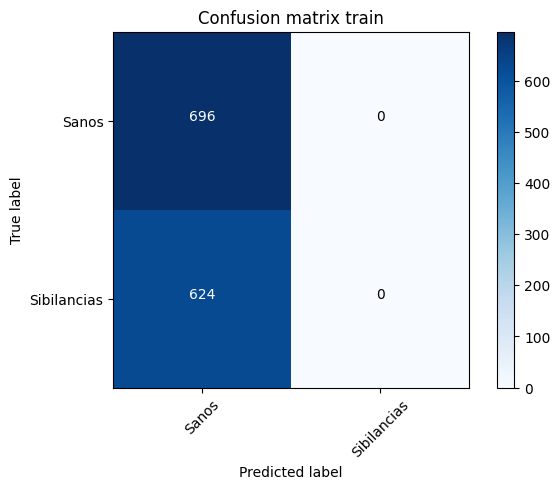

In [ ]:
#Matriz de confusión sujetos de entrenamiento
mc_train_3 = confusion_matrix(y_train,predict_train_3)
plot_confusion_matrix(mc_train_3, classes=target_names,
                      title='Confusion matrix train')

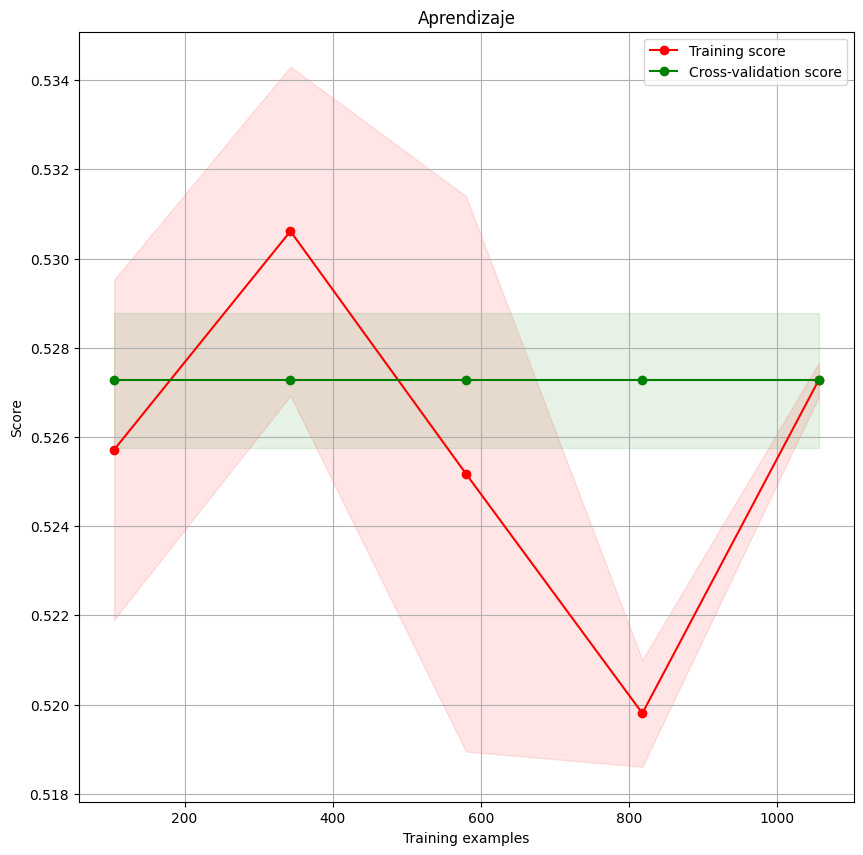

In [ ]:
#Curva de aprendizaje
plot_learning_curve(estimator=clf_3,
                    X=X_train,
                    y=y_train,
                    title='Aprendizaje')
plt.show()

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

       Sanos       0.54      1.00      0.70       304
  Sibilancia       0.00      0.00      0.00       262

    accuracy                           0.54       566
   macro avg       0.27      0.50      0.35       566
weighted avg       0.29      0.54      0.38       566

Confusion matrix, without normalization
[[304   0]
 [262   0]]


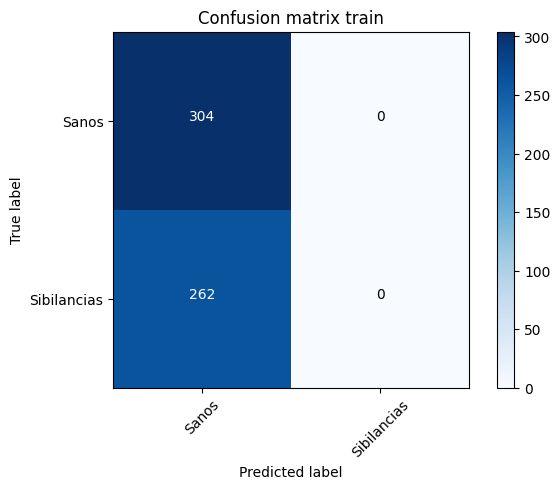

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

       Sanos       0.54      1.00      0.70       304
  Sibilancia       0.00      0.00      0.00       262

    accuracy                           0.54       566
   macro avg       0.27      0.50      0.35       566
weighted avg       0.29      0.54      0.38       566

Confusion matrix, without normalization
[[304   0]
 [262   0]]


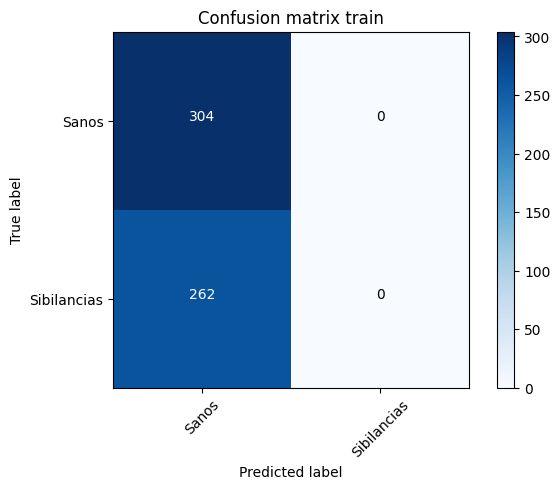

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

       Sanos       0.54      1.00      0.70       304
  Sibilancia       0.00      0.00      0.00       262

    accuracy                           0.54       566
   macro avg       0.27      0.50      0.35       566
weighted avg       0.29      0.54      0.38       566

Confusion matrix, without normalization
[[304   0]
 [262   0]]


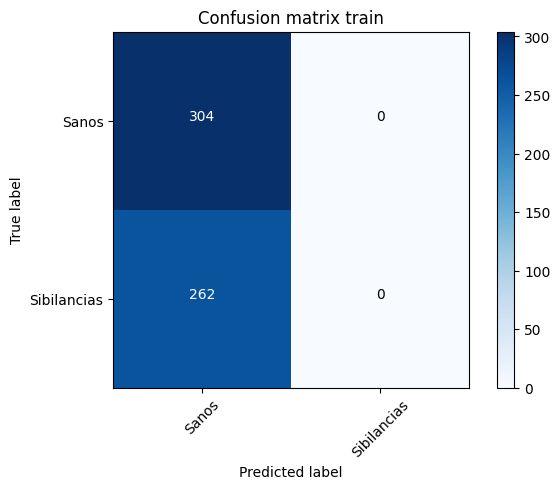

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

       Sanos       0.54      1.00      0.70       304
  Sibilancia       0.00      0.00      0.00       262

    accuracy                           0.54       566
   macro avg       0.27      0.50      0.35       566
weighted avg       0.29      0.54      0.38       566

Confusion matrix, without normalization
[[304   0]
 [262   0]]


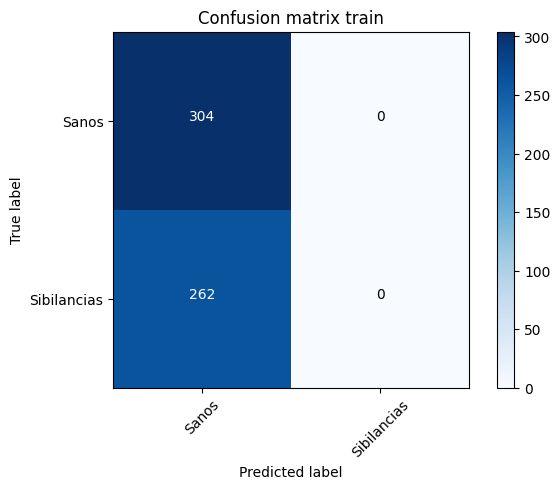

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

       Sanos       0.54      1.00      0.70       304
  Sibilancia       0.00      0.00      0.00       262

    accuracy                           0.54       566
   macro avg       0.27      0.50      0.35       566
weighted avg       0.29      0.54      0.38       566

Confusion matrix, without normalization
[[304   0]
 [262   0]]


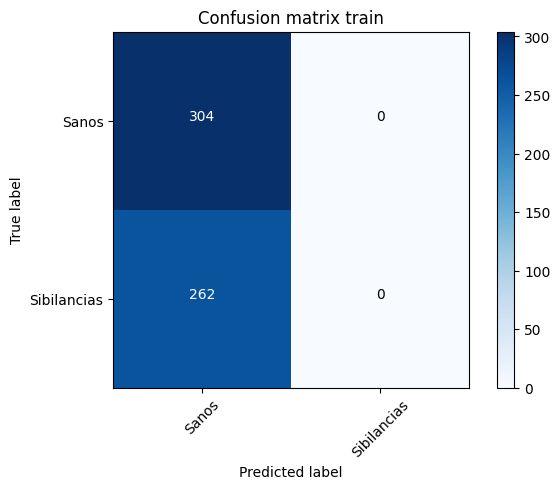

El promedio en validación es de 0.2686


In [ ]:
# Proceso de k-folds
k_folds = KFold(5, random_state=1, shuffle = True)

scores_valid = np.zeros(10)

for pos, (train, test) in enumerate(k_folds.split( X_train, y_train)):

  clf_3.fit(X_train[train], y_train[train])
  y_pred = clf_3.predict(X_test)
  #Se establecen las metricas
  print(classification_report(y_test, y_pred))
  scores_valid[pos] = clf_3.score(X_test,y_test)
  #Se grafica la matriz de confusión
  mc_test = confusion_matrix(y_test,y_pred)
  plot_confusion_matrix(mc_test, classes=target_names,
                      title='Confusion matrix train')
  plt.show()

print(f'El promedio en validación es de {round(scores_valid.mean(),4)}')

Sujetos sanos vs sujetos con crepitancias

In [ ]:
#Se crea un data_frame que solo contenga los sujetos sanos y los sujetos con crepitancia
#sujetos con sibilancias
crepitancia = data_frame_final_.loc[:, 'Clasificación'] == 'Crepitancia'
df_crepitancia = data_frame_final_.loc[crepitancia]
#Sujetos sanos
sanos = data_frame_final_.loc[:, 'Clasificación'] == 'Sanos'
df_sanos = data_frame_final_.loc[sanos]
df_edades_ordenadas = df_sanos.sort_values(by="edad")
y=pd.concat([df_edades_ordenadas[0:1000],df_edades_ordenadas[1500:3000]])
#Se concatenan los data frame de los sujetos sanos y los sujetos con sibilancia
crepitancia_final = pd.concat([df_crepitancia,y])

In [ ]:
print(len(df_crepitancia))

2370


In [ ]:
#Datos de entrenamiento y datos de test
#Se normalizan los datos
crepitancia_final[predictors_] = crepitancia_final[predictors_]/crepitancia_final[predictors_].max()

X_crep = crepitancia_final[predictors_].values
y_crep = crepitancia_final['Clasificación'].values

#Se distribuyen los datos,, tomando un 30% para prueba
X_train_crep, X_test_crep, y_train_crep, y_test_crep = train_test_split(X_crep, y_crep, test_size=0.30, random_state=40)
y_test_crep = np.squeeze(y_test_crep)
y_train_crep = np.squeeze(y_train_crep)

#Se muestra el tamaño de los datos de entrenamiento y de validación
print(f' Tamaño de las caracteristicas los datos de entrenamiento: {X_train_crep.shape}')
print(f' Tamaño de la salida de los datos de entrenamiento: {y_train_crep.shape}')

print(f' Tamaño de las caracteristicas los datos de prueba: {X_test_crep.shape}')
print(f' Tamaño de la salida de los datos de prueba: {y_test_crep.shape}')

 Tamaño de las caracteristicas los datos de entrenamiento: (3409, 3)
 Tamaño de la salida de los datos de entrenamiento: (3409,)
 Tamaño de las caracteristicas los datos de prueba: (1461, 3)
 Tamaño de la salida de los datos de prueba: (1461,)


Primera arquitectura


In [ ]:
'''
  MLPClassifier es una clase de sklearn que permite crear una red neuronal, la
  cual tiene como argumentos:

  - hidden_layer_sizes: Con este parámetro podemos especificar el número de capas
  y el número de nodos que queremos tener en el Clasificador de Redes Neuronales.
  Cada elemento de la tupla representa el número de nodos en la i-ésima posición,
  donde i es el índice de la tupla. Así, la longitud de la tupla indica el
  número total de capas ocultas en la red neuronal.
  - activation: es la funcion de activacion de la capa oculta.
  - solver: es el solucionador para la optimización del peso sobre los nodos.
  - max_iter: es el numero máximo de iteraciones (número de epocas).
'''

#Se crea la red neuronal

#Seleccionamos 3 capas de neuronas ocultas, con 30 nodos cada una.

mlp_crep = MLPClassifier(hidden_layer_sizes=(20,20,20), activation='relu', solver='adam', max_iter=10000)

#Se visualiza la red

print(mlp_crep)

MLPClassifier(hidden_layer_sizes=(20, 20, 20), max_iter=10000)


In [ ]:
#Se entrena el modelo y se realizan las predicciones
mlp_crep.fit(X_train_crep,y_train_crep)

predict_train_crep = mlp_crep.predict(X_train_crep)
predict_test_crep = mlp_crep.predict(X_test_crep)

In [ ]:
target_names_crep = ['Sanos','Crepitancias']

#Se visualizan las metricas para medir el rendimiento de los algoritmos

print(classification_report(y_train_crep,predict_train_crep, target_names= target_names_crep))
print(classification_report(y_test_crep,predict_test_crep,target_names= target_names_crep))

              precision    recall  f1-score   support

       Sanos       0.59      0.52      0.55      1688
Crepitancias       0.58      0.65      0.61      1721

    accuracy                           0.58      3409
   macro avg       0.59      0.58      0.58      3409
weighted avg       0.59      0.58      0.58      3409

              precision    recall  f1-score   support

       Sanos       0.57      0.52      0.55       682
Crepitancias       0.61      0.66      0.63       779

    accuracy                           0.59      1461
   macro avg       0.59      0.59      0.59      1461
weighted avg       0.59      0.59      0.59      1461



Confusion matrix, without normalization
[[ 873  815]
 [ 601 1120]]


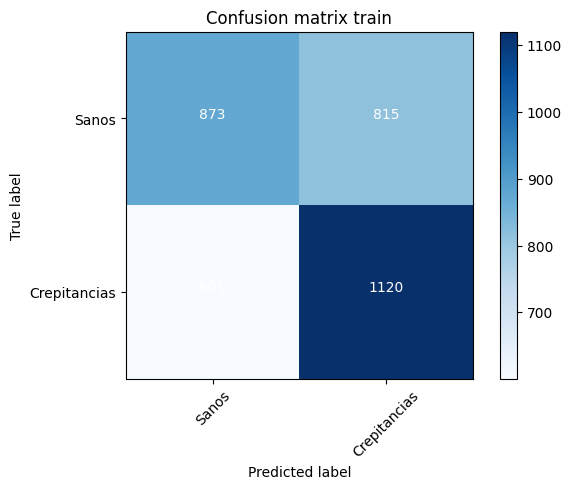

In [ ]:
#Se saca la matriz de confusion, que permite evaluar la presición de una clasificación
#Se hace para los datos de entrenmiento
mc_train_crep = confusion_matrix(y_train_crep,predict_train_crep)
plot_confusion_matrix(mc_train_crep, classes=target_names_crep,
                      title='Confusion matrix train')

Confusion matrix, without normalization
[[356 326]
 [267 512]]


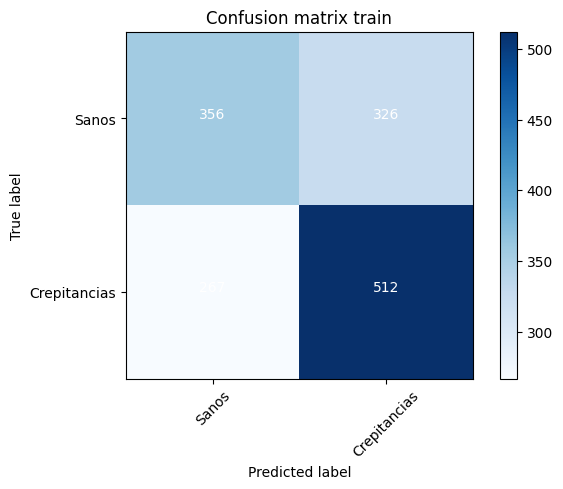

In [ ]:
#Se hace la matriz de confusión para los datos de prueba
mc_test_crep = confusion_matrix(y_test_crep,predict_test_crep)
plot_confusion_matrix(mc_test_crep, classes=target_names,
                      title='Confusion matrix train')

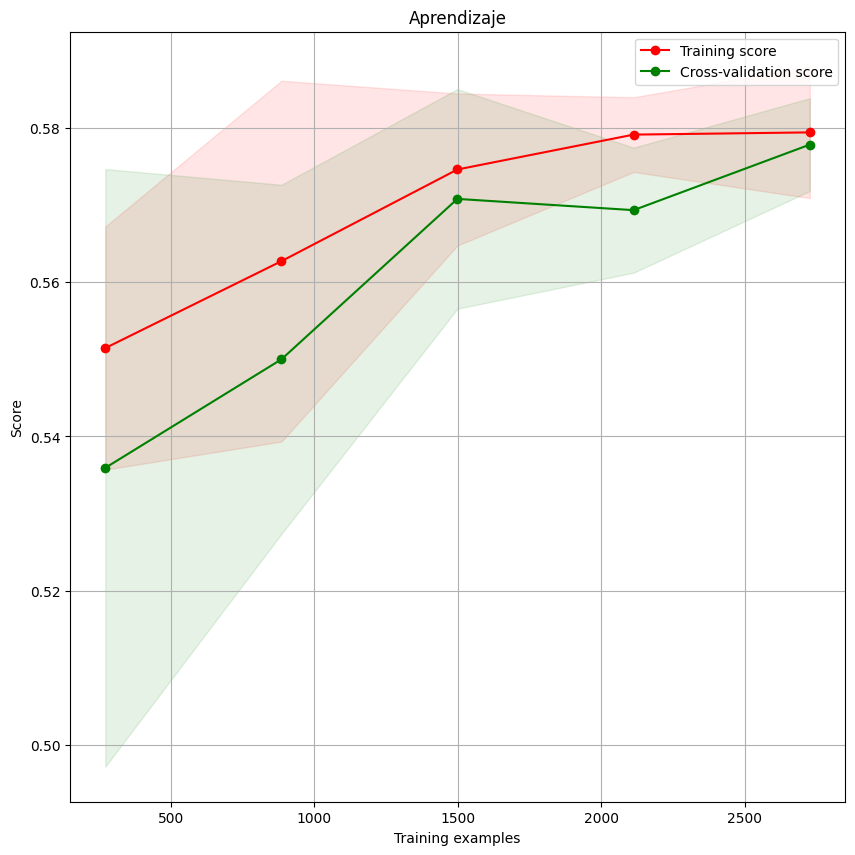

In [ ]:
#Se grafica la gurva de aprendizaje
plot_learning_curve(estimator=mlp_crep,
                    X=X_train_crep,
                    y=y_train_crep,
                    title='Aprendizaje')
plt.show()

              precision    recall  f1-score   support

 Crepitancia       0.58      0.43      0.49       682
       Sanos       0.59      0.73      0.65       779

    accuracy                           0.59      1461
   macro avg       0.59      0.58      0.57      1461
weighted avg       0.59      0.59      0.58      1461

Confusion matrix, without normalization
[[293 389]
 [212 567]]


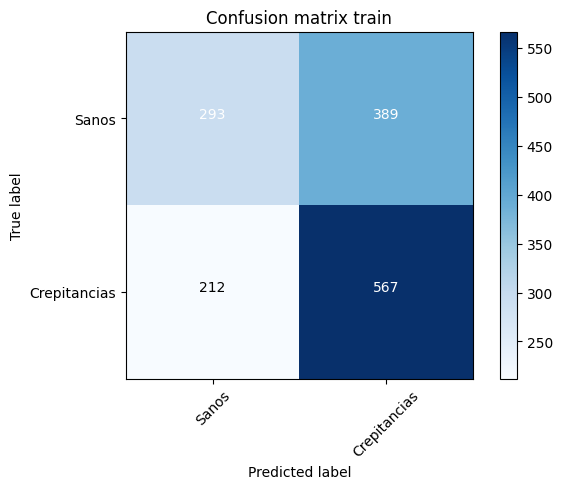

              precision    recall  f1-score   support

 Crepitancia       0.58      0.46      0.51       682
       Sanos       0.60      0.70      0.65       779

    accuracy                           0.59      1461
   macro avg       0.59      0.58      0.58      1461
weighted avg       0.59      0.59      0.58      1461

Confusion matrix, without normalization
[[314 368]
 [232 547]]


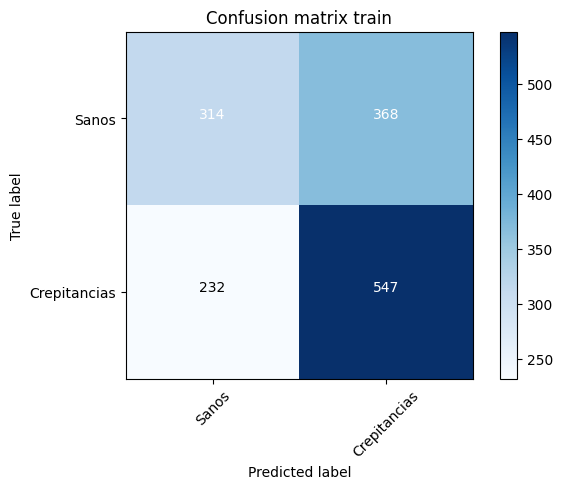

              precision    recall  f1-score   support

 Crepitancia       0.58      0.50      0.53       682
       Sanos       0.61      0.69      0.64       779

    accuracy                           0.60      1461
   macro avg       0.59      0.59      0.59      1461
weighted avg       0.59      0.60      0.59      1461

Confusion matrix, without normalization
[[338 344]
 [245 534]]


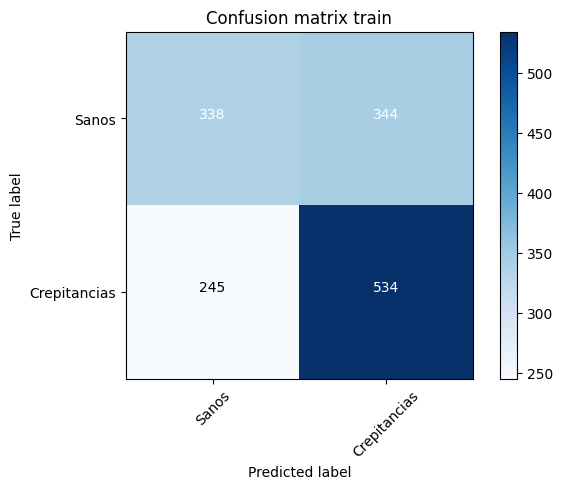

              precision    recall  f1-score   support

 Crepitancia       0.58      0.46      0.52       682
       Sanos       0.60      0.71      0.65       779

    accuracy                           0.59      1461
   macro avg       0.59      0.59      0.58      1461
weighted avg       0.59      0.59      0.59      1461

Confusion matrix, without normalization
[[317 365]
 [227 552]]


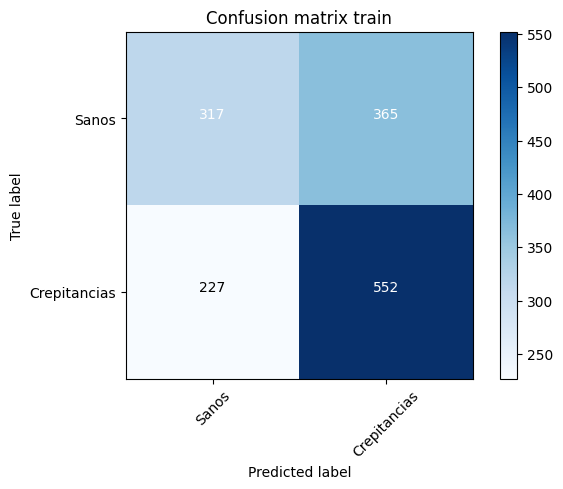

              precision    recall  f1-score   support

 Crepitancia       0.58      0.56      0.57       682
       Sanos       0.62      0.64      0.63       779

    accuracy                           0.60      1461
   macro avg       0.60      0.60      0.60      1461
weighted avg       0.60      0.60      0.60      1461

Confusion matrix, without normalization
[[379 303]
 [277 502]]


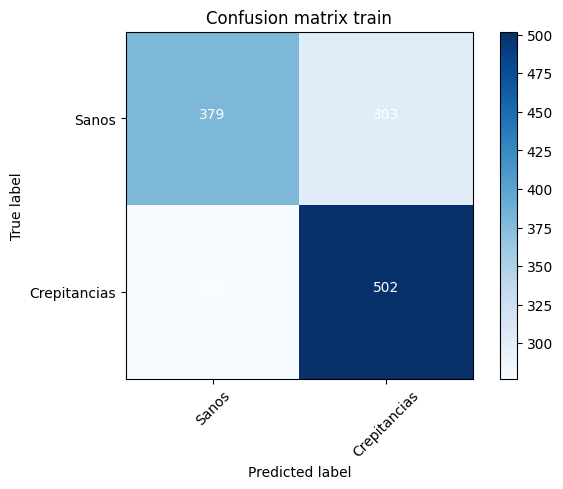

El promedio en validación es de 0.2973


In [ ]:
# Proceso de k-folds
k_folds = KFold(5, random_state=1, shuffle = True)

scores_valid = np.zeros(10)

for pos, (train, test) in enumerate(k_folds.split( X_train_crep, y_train_crep)):
  #Se entrenan los datos y se establece el y predicho
  mlp_crep.fit(X_train_crep[train], y_train_crep[train])
  y_pred_crep = mlp_crep.predict(X_test_crep)
  #Se establecen las metricas
  print(classification_report(y_test_crep, y_pred_crep))
  scores_valid[pos] = mlp_crep.score(X_test_crep,y_test_crep)
  #Se grafica la matriz de confusión
  mc_test = confusion_matrix(y_test_crep,y_pred_crep)
  plot_confusion_matrix(mc_test, classes=target_names,
                      title='Confusion matrix train')
  plt.show()

print(f'El promedio en validación es de {round(scores_valid.mean(),4)}')

#Arquitectura2


In [ ]:
clf_2 = MLPClassifier(hidden_layer_sizes=(100,100,100,100), activation='relu', solver='adam', max_iter=10000)

In [ ]:
#Entrenamiento del modelo y predicciones
clf_2.fit(X_train_crep,y_train_crep)

predict_train_2_c = clf_2.predict(X_train_crep)
predict_test_2_c= clf_2.predict(X_test_crep)

In [ ]:
#Metricas
target_names = ['Sanos', 'Crepitancias']
print(classification_report(y_train_crep,predict_train_2_c,target_names=target_names))
print(classification_report(y_test_crep,predict_test_2_c,target_names=target_names))

              precision    recall  f1-score   support

       Sanos       0.59      0.49      0.54      1688
Crepitancias       0.57      0.67      0.62      1721

    accuracy                           0.58      3409
   macro avg       0.58      0.58      0.58      3409
weighted avg       0.58      0.58      0.58      3409

              precision    recall  f1-score   support

       Sanos       0.58      0.49      0.53       682
Crepitancias       0.61      0.69      0.65       779

    accuracy                           0.60      1461
   macro avg       0.59      0.59      0.59      1461
weighted avg       0.59      0.60      0.59      1461



Confusion matrix, without normalization
[[333 349]
 [242 537]]


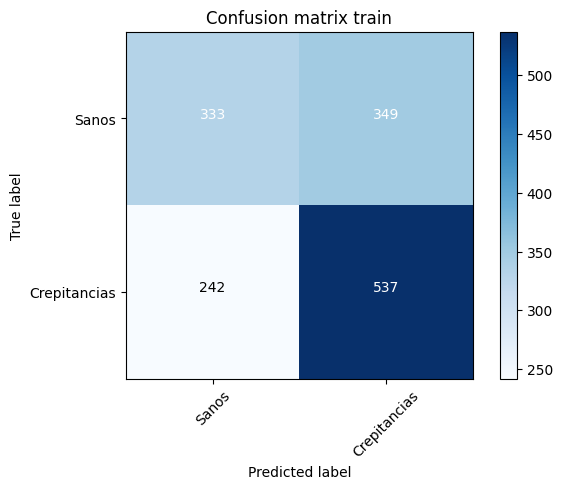

In [ ]:
#Matriz de confusión sujetos de prueba
mc_test_2_c = confusion_matrix(y_test_crep,predict_test_2_c)
plot_confusion_matrix(mc_test_2_c, classes=target_names,
                      title='Confusion matrix train')

Confusion matrix, without normalization
[[ 826  862]
 [ 566 1155]]


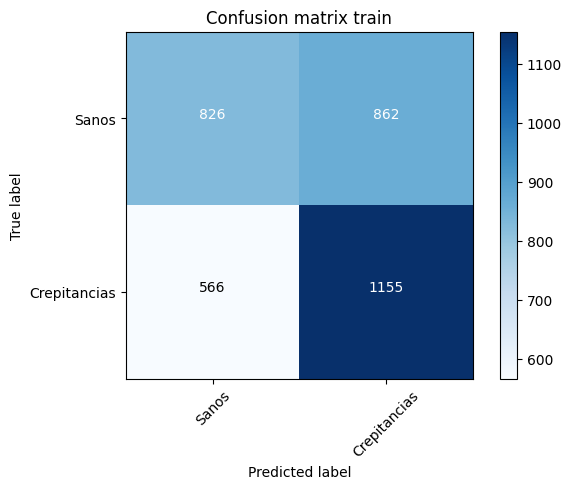

In [ ]:
#Matriz de confusión sujetos de entrenamiento
mc_train_2_c = confusion_matrix(y_train_crep,predict_train_2_c)
plot_confusion_matrix(mc_train_2_c, classes=target_names,
                      title='Confusion matrix train')

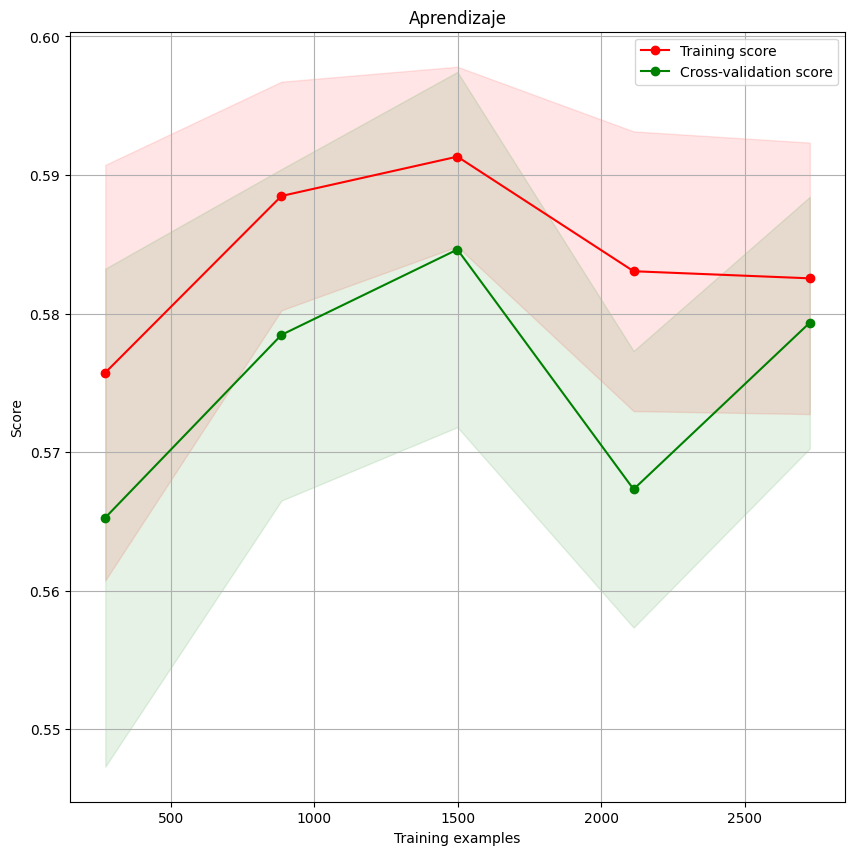

In [ ]:
#Curva de aprendizaje
plot_learning_curve(estimator=clf_2,
                    X=X_train_crep,
                    y=y_train_crep,
                    title='Aprendizaje')
plt.show()

              precision    recall  f1-score   support

 Crepitancia       0.59      0.34      0.43       682
       Sanos       0.58      0.80      0.67       779

    accuracy                           0.58      1461
   macro avg       0.59      0.57      0.55      1461
weighted avg       0.59      0.58      0.56      1461

Confusion matrix, without normalization
[[229 453]
 [156 623]]


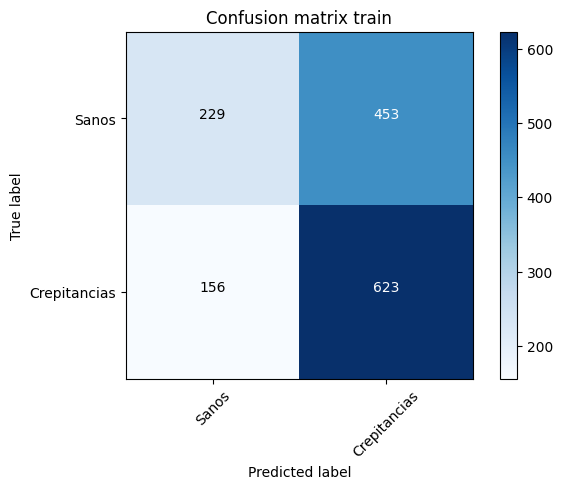

              precision    recall  f1-score   support

 Crepitancia       0.57      0.59      0.58       682
       Sanos       0.63      0.62      0.62       779

    accuracy                           0.61      1461
   macro avg       0.60      0.60      0.60      1461
weighted avg       0.61      0.61      0.61      1461

Confusion matrix, without normalization
[[404 278]
 [299 480]]


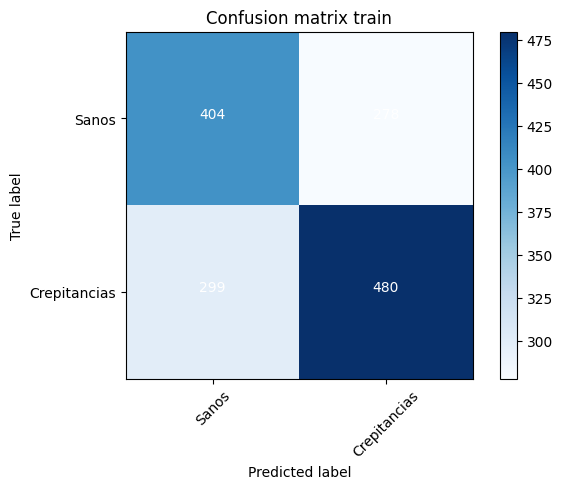

              precision    recall  f1-score   support

 Crepitancia       0.57      0.45      0.50       682
       Sanos       0.59      0.71      0.65       779

    accuracy                           0.59      1461
   macro avg       0.58      0.58      0.58      1461
weighted avg       0.59      0.59      0.58      1461

Confusion matrix, without normalization
[[305 377]
 [226 553]]


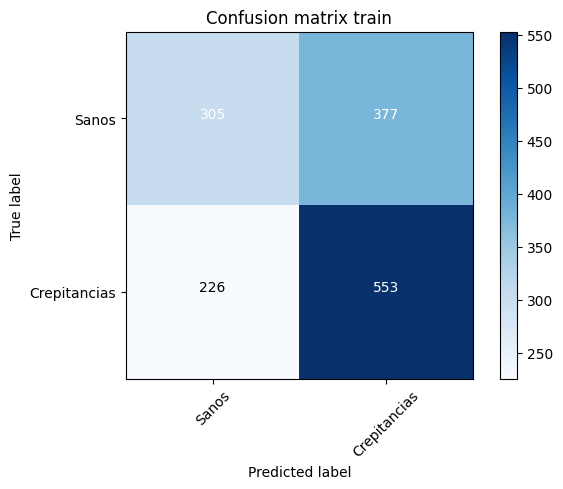

              precision    recall  f1-score   support

 Crepitancia       0.57      0.62      0.59       682
       Sanos       0.64      0.60      0.62       779

    accuracy                           0.61      1461
   macro avg       0.61      0.61      0.60      1461
weighted avg       0.61      0.61      0.61      1461

Confusion matrix, without normalization
[[420 262]
 [315 464]]


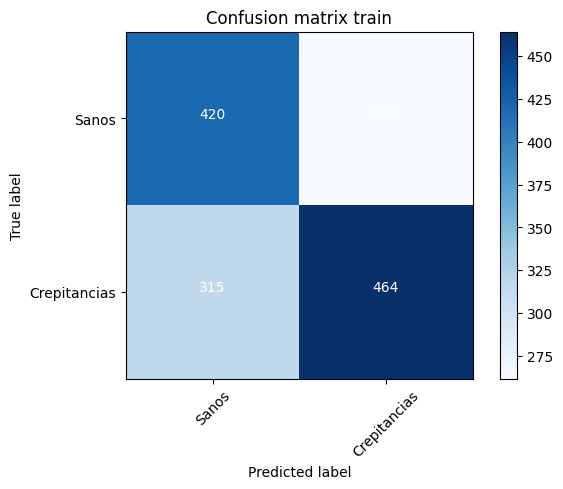

              precision    recall  f1-score   support

 Crepitancia       0.56      0.63      0.59       682
       Sanos       0.64      0.57      0.60       779

    accuracy                           0.60      1461
   macro avg       0.60      0.60      0.60      1461
weighted avg       0.60      0.60      0.60      1461

Confusion matrix, without normalization
[[428 254]
 [334 445]]


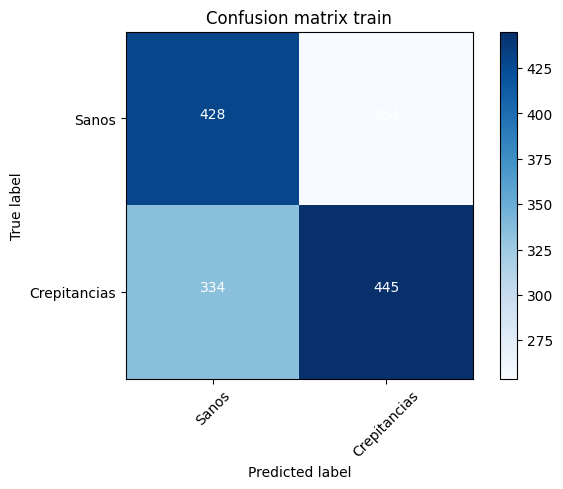

El promedio en validación es de 0.2978


In [ ]:
# Proceso de k-folds
k_folds = KFold(5, random_state=1, shuffle = True)

scores_valid = np.zeros(10)

for pos, (train, test) in enumerate(k_folds.split( X_train_crep, y_train_crep)):
  #Se entrenan los datos y se establece el y predicho
  clf_2.fit(X_train_crep[train], y_train_crep[train])
  y_pred_crep = clf_2.predict(X_test_crep)
  #Se establecen las metricas de evaluación
  print(classification_report(y_test_crep, y_pred_crep))
  scores_valid[pos] = clf_2.score(X_test_crep,y_test_crep)

  mc_test_2 = confusion_matrix(y_test_crep,y_pred_crep)
  plot_confusion_matrix(mc_test_2, classes=target_names,
                      title='Confusion matrix train')
  plt.show()

print(f'El promedio en validación es de {round(scores_valid.mean(),4)}')

In [ ]:
clf_3 = MLPClassifier((100,100,100,100,100,100), #Tamaño de la red
                      max_iter=1000, #Número de iteraciones
                      activation='relu', # Función de activación
                      solver='sgd', # optimizador de función de perdida
) #Evitar sobre entrenamiento en la convergencia del optimizador

In [ ]:
#Entrenamiento del modelo y predicciones
clf_3.fit(X_train_crep, y_train_crep)

predict_train_3_c = clf_3.predict(X_train_crep)
predict_test_3_c = clf_3.predict(X_test_crep)

In [ ]:

#Metricas
target_names = ['Sanos', 'Crepitancias']
print(classification_report(y_train_crep,predict_train_3_c,target_names=target_names))
print(classification_report(y_test_crep,predict_test_3_c,target_names=target_names))

              precision    recall  f1-score   support

       Sanos       0.67      0.00      0.01      1688
Crepitancias       0.51      1.00      0.67      1721

    accuracy                           0.51      3409
   macro avg       0.59      0.50      0.34      3409
weighted avg       0.59      0.51      0.34      3409

              precision    recall  f1-score   support

       Sanos       1.00      0.00      0.01       682
Crepitancias       0.53      1.00      0.70       779

    accuracy                           0.54      1461
   macro avg       0.77      0.50      0.35      1461
weighted avg       0.75      0.54      0.38      1461



Confusion matrix, without normalization
[[  3 679]
 [  0 779]]


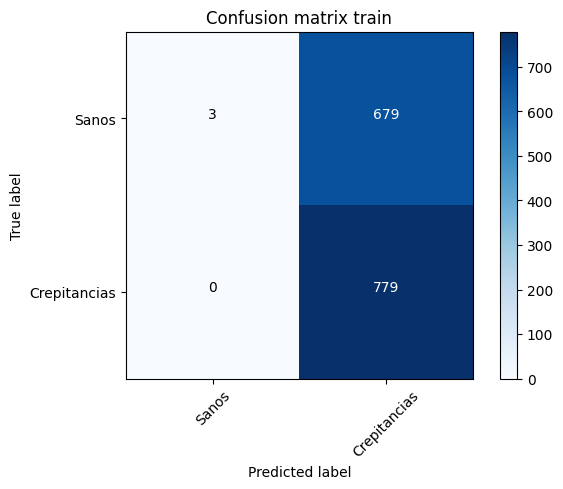

In [ ]:
#Matriz de confusión sujetos de prueba
mc_test_3_c = confusion_matrix(y_test_crep,predict_test_3_c)
plot_confusion_matrix(mc_test_3_c, classes=target_names,
                      title='Confusion matrix train')

Confusion matrix, without normalization
[[   6 1682]
 [   3 1718]]


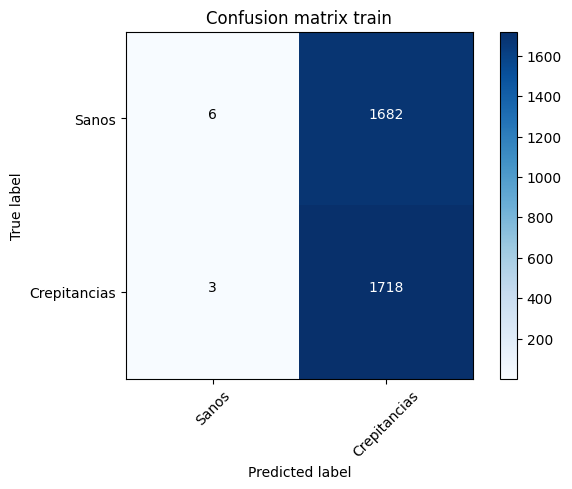

In [ ]:
#Matriz de confusión sujetos de entrenamiento
mc_train_3_c = confusion_matrix(y_train_crep,predict_train_3_c)
plot_confusion_matrix(mc_train_3_c, classes=target_names,
                      title='Confusion matrix train')

En la matriz de confusión obtenidas para datos de entrenamiento y datos de prueba, se establece que el modelo presenta un valor muy alto de re call, en precisión y en f1-score para los sujetos con crepitancia, pero para los sujetos sanos, presenta valores pequeños, siendo erronea su clasificación.

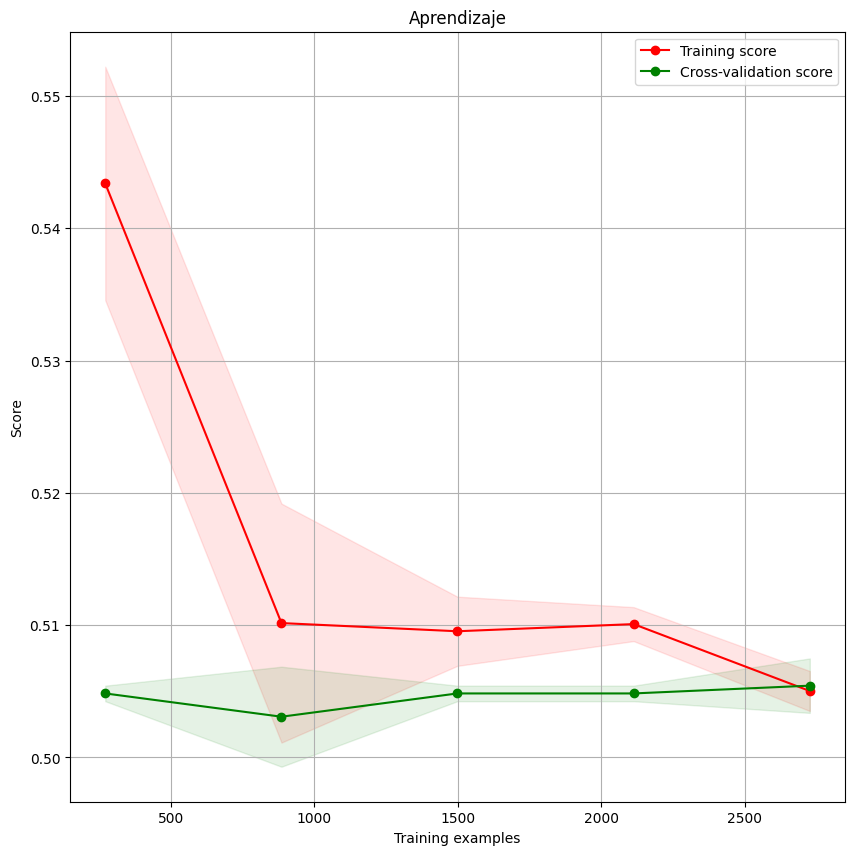

In [ ]:
#Curva de aprendizaje
plot_learning_curve(estimator=clf_3,
                    X=X_train_crep,
                    y=y_train_crep,
                    title='Aprendizaje')
plt.show()

En el modelo anterior según las curvas obtenidas se puede evidenciar que el modelo no presenta mejoras en los datos de validación, ni en los datos  de entrenamiento, evidenciando que la curva en los datos de entrenamiento tiende a aumentar, presentando convergencia en un punto que no es ideal.



In [ ]:
# Proceso de k-folds
k_folds = KFold(5, random_state=1, shuffle = True)

scores_valid = np.zeros(10)

for pos, (train, test) in enumerate(k_folds.split(X_train_crep, y_train_crep)):

  clf_3.fit(X_train_crep[train], y_train_crep[train])
  y_pred_crep_ = clf_3.predict(X_test_crep)
  #Se establecen las metricas
  print(classification_report(y_test_crep, y_pred_crep_))
  scores_valid[pos] = clf_3.score(X_test_crep,y_test_crep)

print(f'El promedio en validación es de {round(scores_valid.mean(),4)}')

              precision    recall  f1-score   support

 Crepitancia       0.47      0.99      0.64       682
       Sanos       0.55      0.01      0.02       779

    accuracy                           0.47      1461
   macro avg       0.51      0.50      0.33      1461
weighted avg       0.51      0.47      0.30      1461



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

 Crepitancia       0.00      0.00      0.00       682
       Sanos       0.53      1.00      0.70       779

    accuracy                           0.53      1461
   macro avg       0.27      0.50      0.35      1461
weighted avg       0.28      0.53      0.37      1461



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

 Crepitancia       0.00      0.00      0.00       682
       Sanos       0.53      1.00      0.70       779

    accuracy                           0.53      1461
   macro avg       0.27      0.50      0.35      1461
weighted avg       0.28      0.53      0.37      1461



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

 Crepitancia       0.00      0.00      0.00       682
       Sanos       0.53      1.00      0.70       779

    accuracy                           0.53      1461
   macro avg       0.27      0.50      0.35      1461
weighted avg       0.28      0.53      0.37      1461

              precision    recall  f1-score   support

 Crepitancia       0.47      0.99      0.64       682
       Sanos       0.70      0.02      0.04       779

    accuracy                           0.47      1461
   macro avg       0.58      0.51      0.34      1461
weighted avg       0.59      0.47      0.32      1461

El promedio en validación es de 0.254


#CREPITANCIAS VS SIBILANCIAS

In [ ]:
#Se crea un data_frame que solo contenga los sujetos sanos y los sujetos con crepitancia
#sujetos con sibilancias
crepitancia = data_frame_final_.loc[:, 'Clasificación'] == 'Crepitancia'
df_crepitancia = data_frame_final_.loc[crepitancia]

df_edades_ordenadas = df_crepitancia.sort_values(by="edad")
z=pd.concat([df_edades_ordenadas[0:500],df_edades_ordenadas[1500:2000]])

sibilancia = data_frame_final_.loc[:, 'Clasificación'] == 'Sibilancia'
df_sibilancias = data_frame_final_.loc[sibilancia]

#Se concatenan los data frame de los sujetos sanos y los sujetos con sibilancia
sibilancias_final = pd.concat([df_sibilancias,z])

In [ ]:
#Datos de entrenamiento y datos de test
#Se normalizan los datos
sibilancias_final[predictors_] = sibilancias_final[predictors_]/sibilancias_final[predictors_].max()

# Se establecen las caracteristicas y la salida del modelo
X = sibilancias_final[predictors_].values
y = sibilancias_final['Clasificación'].values

#Se distribuyen los datos,, tomando un 30% para prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=40)
y_test = np.squeeze(y_test)
y_train = np.squeeze(y_train)

#Se muestra el tamaño de los datos
print(f' Tamaño de las caracteristicas los datos de entrenamiento: {X_train.shape}')
print(f' Tamaño de la salida de los datos de entrenamiento: {y_train.shape}')

print(f' Tamaño de las caracteristicas los datos de prueba: {X_test.shape}')
print(f' Tamaño de la salida de los datos de prueba: {y_test.shape}')

 Tamaño de las caracteristicas los datos de entrenamiento: (1320, 3)
 Tamaño de la salida de los datos de entrenamiento: (1320,)
 Tamaño de las caracteristicas los datos de prueba: (566, 3)
 Tamaño de la salida de los datos de prueba: (566,)


#Arquitectura 1

              precision    recall  f1-score   support

Crepitancias       0.55      0.91      0.69       696
 Sibilancias       0.65      0.18      0.28       624

    accuracy                           0.57      1320
   macro avg       0.60      0.55      0.49      1320
weighted avg       0.60      0.57      0.50      1320

              precision    recall  f1-score   support

Crepitancias       0.58      0.94      0.72       304
 Sibilancias       0.76      0.21      0.33       262

    accuracy                           0.60       566
   macro avg       0.67      0.58      0.53       566
weighted avg       0.66      0.60      0.54       566

Confusion matrix, without normalization
[[286  18]
 [206  56]]
Confusion matrix, without normalization
[[635  61]
 [511 113]]


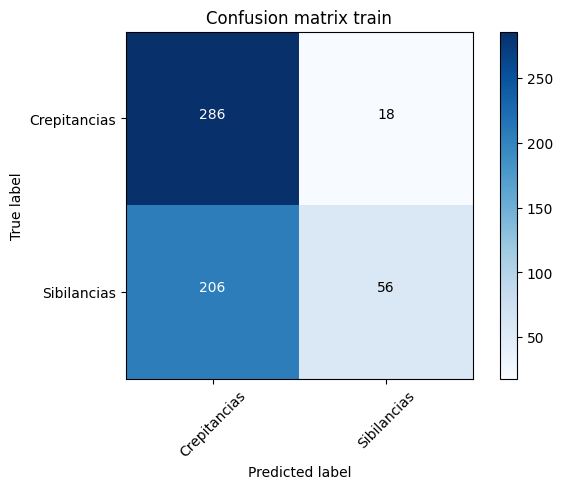

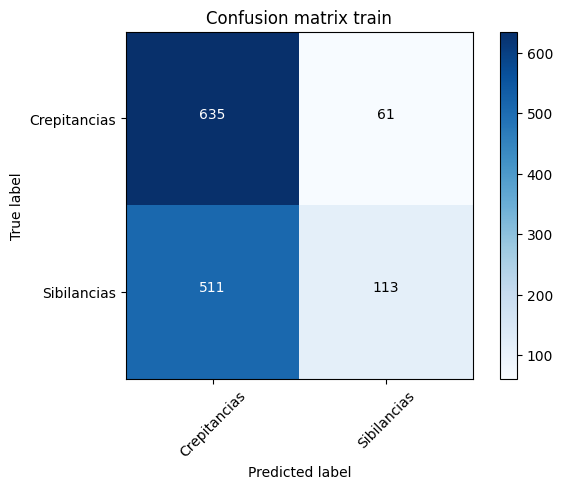

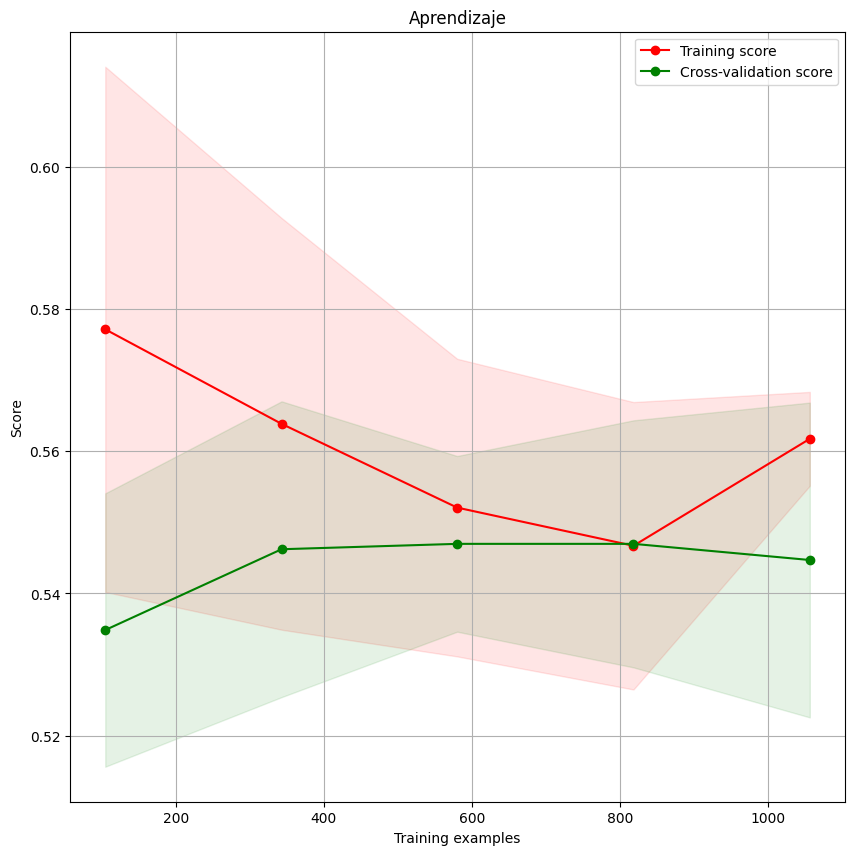

In [ ]:
mlp_sib = MLPClassifier(hidden_layer_sizes=(20,20,20), activation='relu', solver='adam', max_iter=1000)
#Se entrena el modelo y se realizan las predicciones
mlp_sib.fit(X_train,y_train)

predict_train = mlp_sib.predict(X_train)
predict_test = mlp_sib.predict(X_test)

#Metricas
target_names = ['Crepitancias','Sibilancias']
print(classification_report(y_train,predict_train,target_names=target_names))
print(classification_report(y_test,predict_test,target_names=target_names))
#Matriz de confusión sujetos de prueba
mc_test = confusion_matrix(y_test,predict_test)
plot_confusion_matrix(mc_test, classes=target_names,
                      title='Confusion matrix train')
#Matriz de confusión sujetos de entrenamiento
mc_train = confusion_matrix(y_train,predict_train)
plot_confusion_matrix(mc_train, classes=target_names,
                      title='Confusion matrix train')
#Se genera la curva de aprendizaje
plot_learning_curve(estimator=mlp_sib,
                    X=X_train,
                    y=y_train,
                    title='Aprendizaje')
plt.show()

              precision    recall  f1-score   support

 Crepitancia       0.56      0.99      0.72       304
  Sibilancia       0.87      0.10      0.18       262

    accuracy                           0.58       566
   macro avg       0.72      0.54      0.45       566
weighted avg       0.70      0.58      0.47       566

Confusion matrix, without normalization
[[300   4]
 [235  27]]


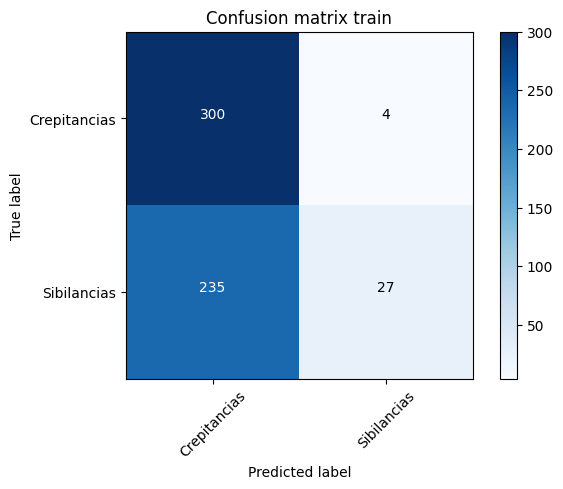

              precision    recall  f1-score   support

 Crepitancia       0.55      0.99      0.71       304
  Sibilancia       0.82      0.07      0.13       262

    accuracy                           0.56       566
   macro avg       0.68      0.53      0.42       566
weighted avg       0.67      0.56      0.44       566

Confusion matrix, without normalization
[[300   4]
 [244  18]]


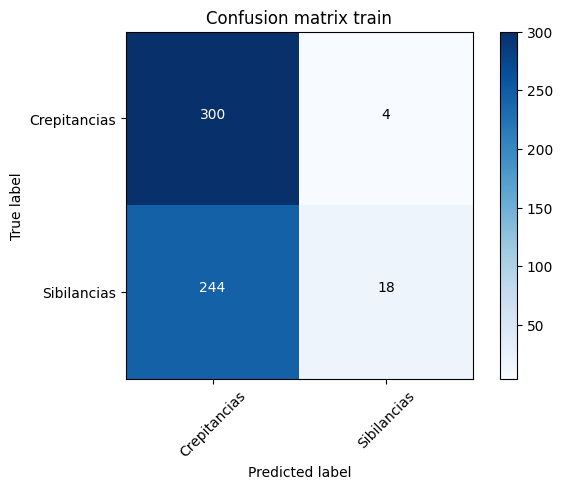

              precision    recall  f1-score   support

 Crepitancia       0.56      0.97      0.71       304
  Sibilancia       0.78      0.11      0.19       262

    accuracy                           0.57       566
   macro avg       0.67      0.54      0.45       566
weighted avg       0.66      0.57      0.47       566

Confusion matrix, without normalization
[[296   8]
 [233  29]]


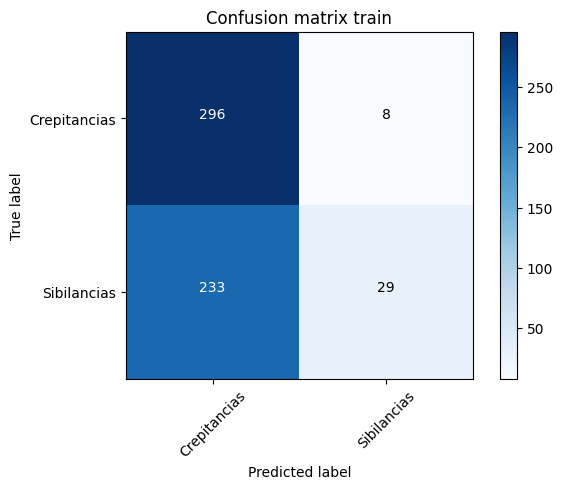

              precision    recall  f1-score   support

 Crepitancia       0.59      0.45      0.51       304
  Sibilancia       0.50      0.64      0.56       262

    accuracy                           0.54       566
   macro avg       0.55      0.55      0.54       566
weighted avg       0.55      0.54      0.54       566

Confusion matrix, without normalization
[[138 166]
 [ 94 168]]


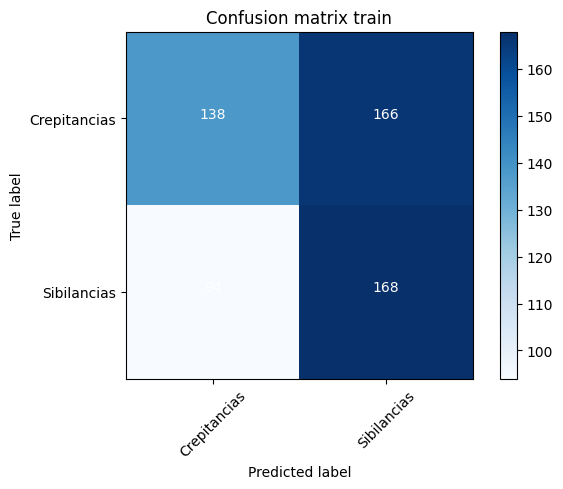

              precision    recall  f1-score   support

 Crepitancia       0.56      0.95      0.71       304
  Sibilancia       0.71      0.13      0.23       262

    accuracy                           0.57       566
   macro avg       0.64      0.54      0.47       566
weighted avg       0.63      0.57      0.48       566

Confusion matrix, without normalization
[[290  14]
 [227  35]]


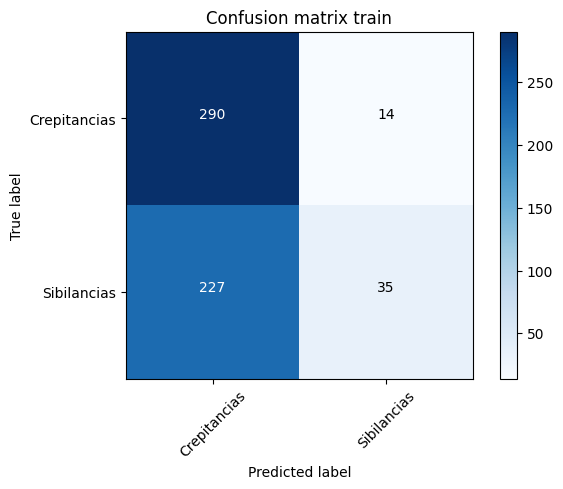

In [ ]:
# Proceso de k-folds
k_folds = KFold(5, random_state=1, shuffle = True)

scores_valid = np.zeros(10)

for pos, (train, test) in enumerate(k_folds.split( X_train, y_train)):
  #Se entrenan los datos y se establece el y predicho
  clf_2.fit(X_train[train], y_train[train])
  y_pred= clf_2.predict(X_test)
  #Se establecen las metricas de evaluación
  print(classification_report(y_test, y_pred))
  scores_valid[pos] = clf_2.score(X_test,y_test)

  mc_test_2 = confusion_matrix(y_test,y_pred)
  plot_confusion_matrix(mc_test_2, classes=target_names,
                      title='Confusion matrix train')
  plt.show()

#arquitectura 2


In [ ]:
mlp_sib = MLPClassifier((100,100,100,100), #Tamaño de la red
                      max_iter=10000, #Número de iteraciones
                      activation='relu', # Función de activación
                      solver='adam', # optimizador de función de perdida
                      learning_rate='adaptive', # Cambios en la tasa de aprendizaje
                      random_state=1,
                      early_stopping=True)

              precision    recall  f1-score   support

Crepitancias       0.55      0.94      0.69       696
 Sibilancias       0.68      0.15      0.24       624

    accuracy                           0.57      1320
   macro avg       0.62      0.54      0.47      1320
weighted avg       0.61      0.57      0.48      1320

              precision    recall  f1-score   support

Crepitancias       0.58      0.96      0.72       304
 Sibilancias       0.82      0.19      0.31       262

    accuracy                           0.61       566
   macro avg       0.70      0.58      0.52       566
weighted avg       0.69      0.61      0.53       566

Confusion matrix, without normalization
[[293  11]
 [212  50]]
Confusion matrix, without normalization
[[653  43]
 [531  93]]


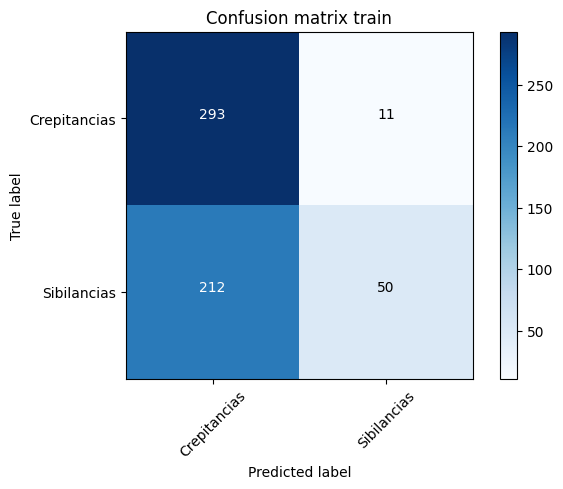

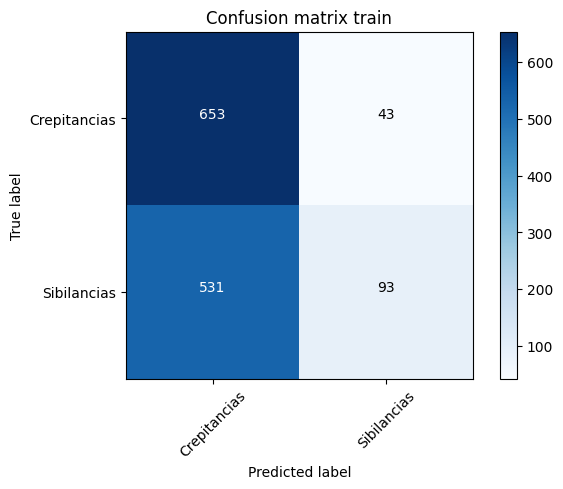

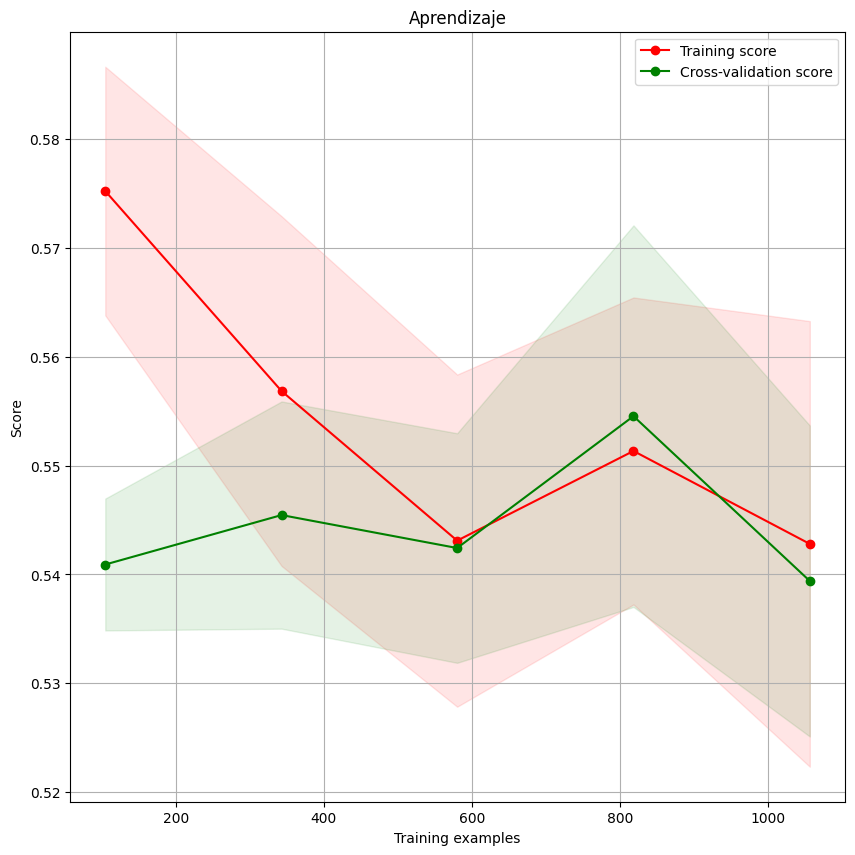

In [ ]:

#Se entrena el modelo y se realizan las predicciones
mlp_sib.fit(X_train,y_train)

predict_train = mlp_sib.predict(X_train)
predict_test = mlp_sib.predict(X_test)

#Metricas
target_names = ['Crepitancias','Sibilancias']
print(classification_report(y_train,predict_train,target_names=target_names))
print(classification_report(y_test,predict_test,target_names=target_names))
#Matriz de confusión sujetos de prueba
mc_test = confusion_matrix(y_test,predict_test)
plot_confusion_matrix(mc_test, classes=target_names,
                      title='Confusion matrix train')
#Matriz de confusión sujetos de entrenamiento
mc_train = confusion_matrix(y_train,predict_train)
plot_confusion_matrix(mc_train, classes=target_names,
                      title='Confusion matrix train')
#Se genera la curva de aprendizaje
plot_learning_curve(estimator=mlp_sib,
                    X=X_train,
                    y=y_train,
                    title='Aprendizaje')
plt.show()

              precision    recall  f1-score   support

 Crepitancia       0.56      0.99      0.72       304
  Sibilancia       0.87      0.10      0.18       262

    accuracy                           0.58       566
   macro avg       0.72      0.54      0.45       566
weighted avg       0.70      0.58      0.47       566

Confusion matrix, without normalization
[[300   4]
 [235  27]]


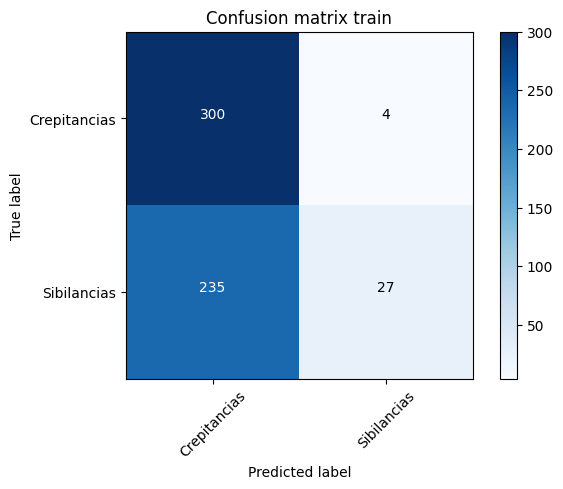

              precision    recall  f1-score   support

 Crepitancia       0.55      0.99      0.71       304
  Sibilancia       0.82      0.07      0.13       262

    accuracy                           0.56       566
   macro avg       0.68      0.53      0.42       566
weighted avg       0.67      0.56      0.44       566

Confusion matrix, without normalization
[[300   4]
 [244  18]]


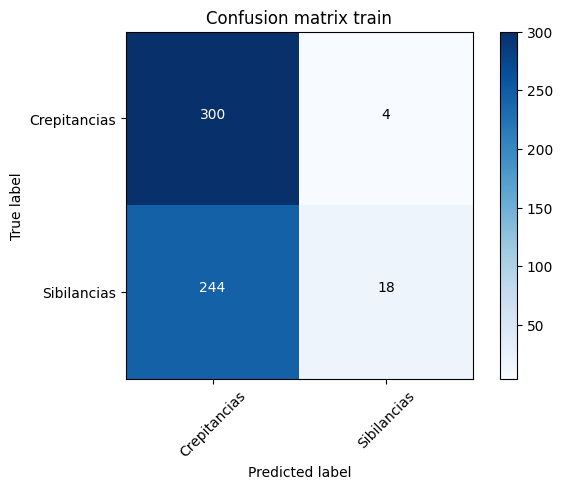

              precision    recall  f1-score   support

 Crepitancia       0.56      0.97      0.71       304
  Sibilancia       0.78      0.11      0.19       262

    accuracy                           0.57       566
   macro avg       0.67      0.54      0.45       566
weighted avg       0.66      0.57      0.47       566

Confusion matrix, without normalization
[[296   8]
 [233  29]]


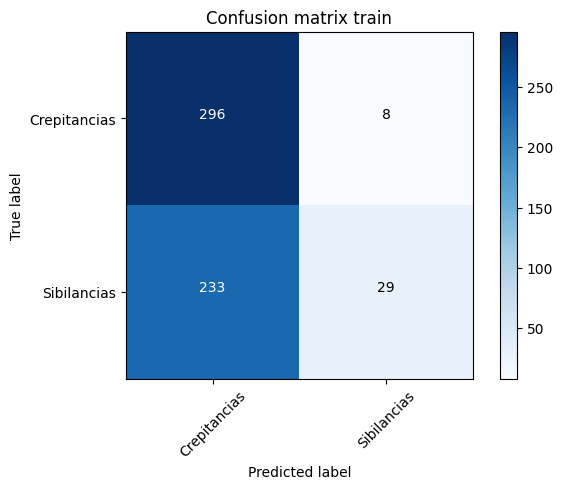

              precision    recall  f1-score   support

 Crepitancia       0.59      0.45      0.51       304
  Sibilancia       0.50      0.64      0.56       262

    accuracy                           0.54       566
   macro avg       0.55      0.55      0.54       566
weighted avg       0.55      0.54      0.54       566

Confusion matrix, without normalization
[[138 166]
 [ 94 168]]


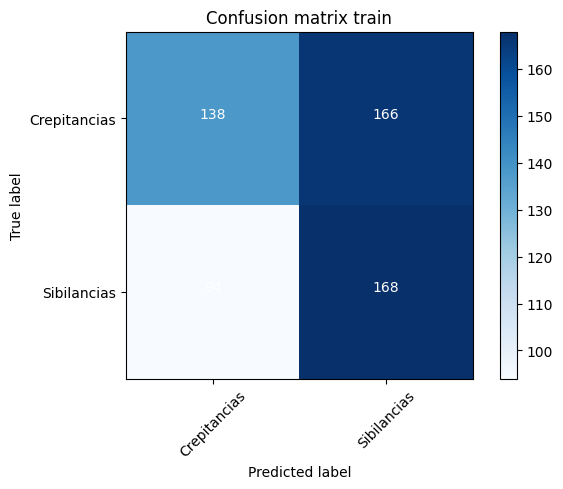

              precision    recall  f1-score   support

 Crepitancia       0.56      0.95      0.71       304
  Sibilancia       0.71      0.13      0.23       262

    accuracy                           0.57       566
   macro avg       0.64      0.54      0.47       566
weighted avg       0.63      0.57      0.48       566

Confusion matrix, without normalization
[[290  14]
 [227  35]]


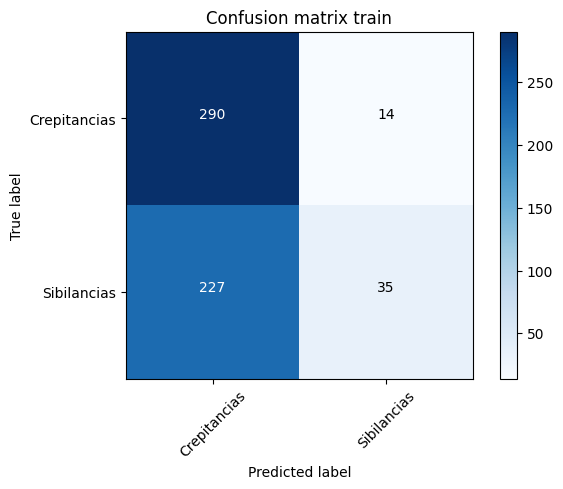

In [ ]:
# Proceso de k-folds
k_folds = KFold(5, random_state=1, shuffle = True)

scores_valid = np.zeros(10)

for pos, (train, test) in enumerate(k_folds.split( X_train, y_train)):
  #Se entrenan los datos y se establece el y predicho
  clf_2.fit(X_train[train], y_train[train])
  y_pred= clf_2.predict(X_test)
  #Se establecen las metricas de evaluación
  print(classification_report(y_test, y_pred))
  scores_valid[pos] = clf_2.score(X_test,y_test)

  mc_test_2 = confusion_matrix(y_test,y_pred)
  plot_confusion_matrix(mc_test_2, classes=target_names,
                      title='Confusion matrix train')
  plt.show()

#3 arquitectura


In [ ]:
mlp_sib= MLPClassifier((100,100,100,100,100,100), #Tamaño de la red
                      max_iter=1000, #Número de iteraciones
                      activation='relu', # Función de activación
                      solver='sgd', # optimizador de función de perdida
                      learning_rate='adaptive', # Cambios en la tasa de aprendizaje
                      random_state=1,
                      early_stopping=True) #Evitar sobre entrenamiento en la convergencia del optimizador

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif

              precision    recall  f1-score   support

Crepitancias       0.53      1.00      0.69       696
 Sibilancias       0.00      0.00      0.00       624

    accuracy                           0.53      1320
   macro avg       0.26      0.50      0.35      1320
weighted avg       0.28      0.53      0.36      1320

              precision    recall  f1-score   support

Crepitancias       0.54      1.00      0.70       304
 Sibilancias       0.00      0.00      0.00       262

    accuracy                           0.54       566
   macro avg       0.27      0.50      0.35       566
weighted avg       0.29      0.54      0.38       566

Confusion matrix, without normalization
[[304   0]
 [262   0]]
Confusion matrix, without normalization
[[696   0]
 [624   0]]


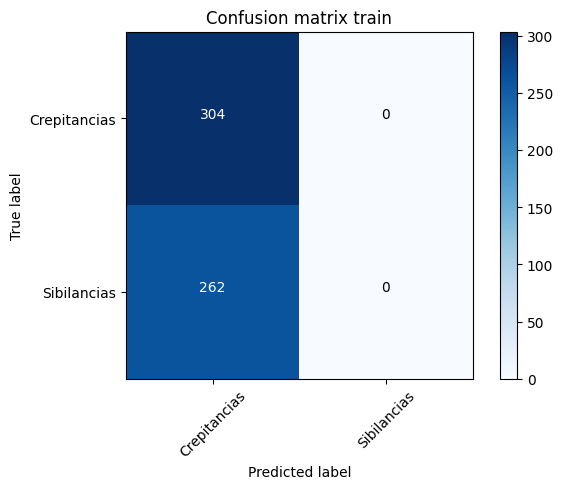

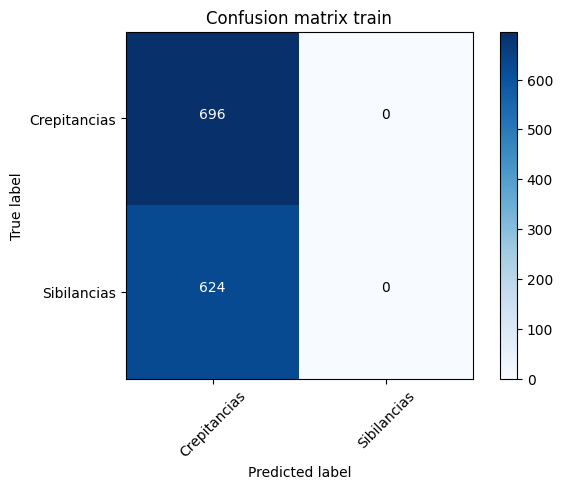

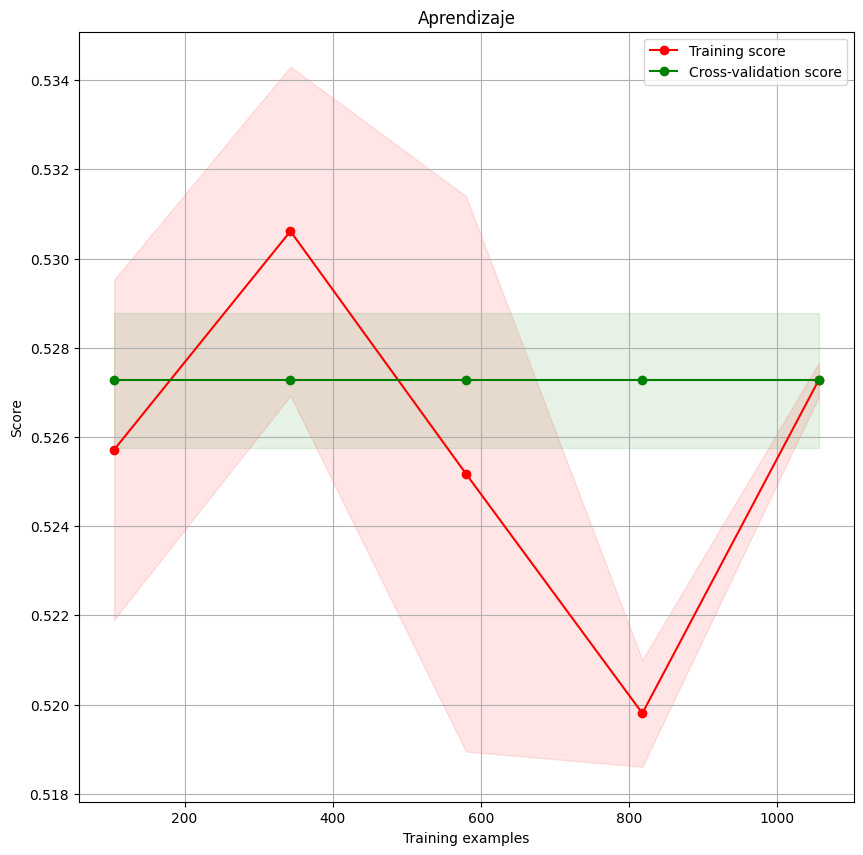

In [ ]:

#Se entrena el modelo y se realizan las predicciones
mlp_sib.fit(X_train,y_train)
predict_train = mlp_sib.predict(X_train)
predict_test = mlp_sib.predict(X_test)

#Metricas
target_names = ['Crepitancias','Sibilancias']
print(classification_report(y_train,predict_train,target_names=target_names))
print(classification_report(y_test,predict_test,target_names=target_names))
#Matriz de confusión sujetos de prueba
mc_test = confusion_matrix(y_test,predict_test)
plot_confusion_matrix(mc_test, classes=target_names,
                      title='Confusion matrix train')
#Matriz de confusión sujetos de entrenamiento
mc_train = confusion_matrix(y_train,predict_train)
plot_confusion_matrix(mc_train, classes=target_names,
                      title='Confusion matrix train')
#Se genera la curva de aprendizaje
plot_learning_curve(estimator=mlp_sib,
                    X=X_train,
                    y=y_train,
                    title='Aprendizaje')
plt.show()

In [ ]:
# Proceso de k-folds
k_folds = KFold(5, random_state=1, shuffle = True)

scores_valid = np.zeros(10)

for pos, (train, test) in enumerate(k_folds.split( X_train, y_train)):
  #Se entrenan los datos y se establece el y predicho
  clf_2.fit(X_train[train], y_train[train])
  y_pred= clf_2.predict(X_test)
  #Se establecen las metricas de evaluación
  print(classification_report(y_test, y_pred))
  scores_valid[pos] = clf_2.score(X_test,y_test)

  mc_test_2 = confusion_matrix(y_test,y_pred)
  plot_confusion_matrix(mc_test_2, classes=target_names,
                      title='Confusion matrix train')
  plt.show()

#sanos,crepitancias y sibilancias

In [ ]:
#Se crea un data_frame que solo contenga los sujetos sanos y los sujetos con crepitancia
#sujetos con sibilancias
crepitancia = data_frame_final_.loc[:, 'Clasificación'] == 'Crepitancia'
df_crepitancia = data_frame_final_.loc[crepitancia]
#Sujetos sanos
sanos = data_frame_final_.loc[:, 'Clasificación'] == 'Sanos'
df_sanos = data_frame_final_.loc[sanos]

df_edades_ordenadas = df_sanos.sort_values(by="edad")
y=pd.concat([df_edades_ordenadas[0:500],df_edades_ordenadas[2000:2500]])

df_edades_ordenadas = df_crepitancia.sort_values(by="edad")
z=pd.concat([df_edades_ordenadas[0:500],df_edades_ordenadas[1500:2000]])

sibilancia = data_frame_final_.loc[:, 'Clasificación'] == 'Sibilancia'
df_sibilancias = data_frame_final_.loc[sibilancia]

#Se concatenan los data frame de los sujetos sanos y los sujetos con sibilancia
sibilancias_final = pd.concat([df_sibilancias,z,y])

In [ ]:
#Datos de entrenamiento y datos de test
#Se normalizan los datos
sibilancias_final[predictors_] = sibilancias_final[predictors_]/sibilancias_final[predictors_].max()

# Se establecen las caracteristicas y la salida del modelo
X = sibilancias_final[predictors_].values
y = sibilancias_final['Clasificación'].values

#Se distribuyen los datos,, tomando un 30% para prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=40)
y_test = np.squeeze(y_test)
y_train = np.squeeze(y_train)

#Se muestra el tamaño de los datos
print(f' Tamaño de las caracteristicas los datos de entrenamiento: {X_train.shape}')
print(f' Tamaño de la salida de los datos de entrenamiento: {y_train.shape}')

print(f' Tamaño de las caracteristicas los datos de prueba: {X_test.shape}')
print(f' Tamaño de la salida de los datos de prueba: {y_test.shape}')

 Tamaño de las caracteristicas los datos de entrenamiento: (2020, 3)
 Tamaño de la salida de los datos de entrenamiento: (2020,)
 Tamaño de las caracteristicas los datos de prueba: (866, 3)
 Tamaño de la salida de los datos de prueba: (866,)


# 1 arquitectura

In [ ]:
mlp_sib = MLPClassifier(hidden_layer_sizes=(20,20,20), activation='relu', solver='adam', max_iter=1000)

In [ ]:
#Se entrena el modelo y se realizan las predicciones
mlp_sib.fit(X_train,y_train)

predict_train = mlp_sib.predict(X_train)
predict_test = mlp_sib.predict(X_test)

              precision    recall  f1-score   support

       Sanos       0.46      0.42      0.44       697
Crepitancias       0.40      0.68      0.50       709
 Sibilancias       0.49      0.14      0.22       614

    accuracy                           0.43      2020
   macro avg       0.45      0.41      0.39      2020
weighted avg       0.45      0.43      0.39      2020

              precision    recall  f1-score   support

       Sanos       0.43      0.41      0.42       303
Crepitancias       0.41      0.71      0.52       291
 Sibilancias       0.49      0.12      0.19       272

    accuracy                           0.42       866
   macro avg       0.44      0.42      0.38       866
weighted avg       0.44      0.42      0.38       866

Confusion matrix, without normalization
[[125 159  19]
 [ 68 207  16]
 [ 96 143  33]]


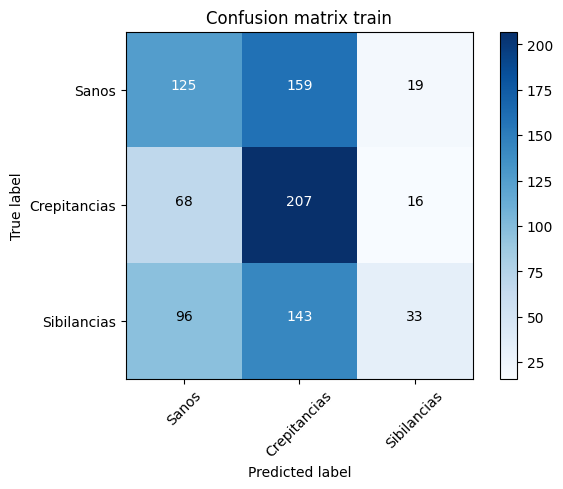

In [ ]:
#Metricas
target_names = ['Sanos','Crepitancias','Sibilancias']
print(classification_report(y_train,predict_train,target_names=target_names))
print(classification_report(y_test,predict_test,target_names=target_names))
#Matriz de confusión sujetos de prueba
mc_test = confusion_matrix(y_test,predict_test)
plot_confusion_matrix(mc_test, classes=target_names,
                      title='Confusion matrix train')

Confusion matrix, without normalization
[[291 377  29]
 [167 483  59]
 [180 348  86]]


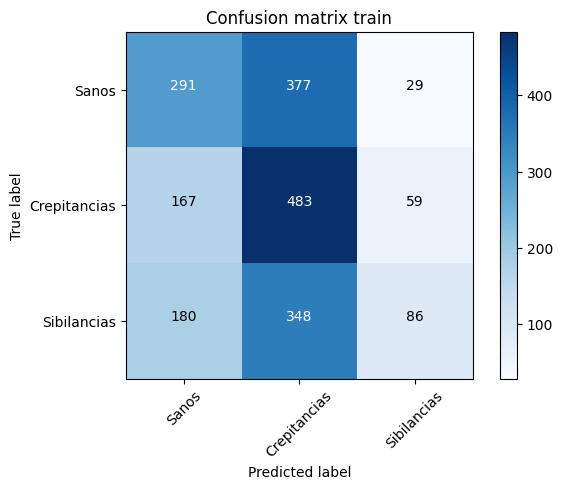

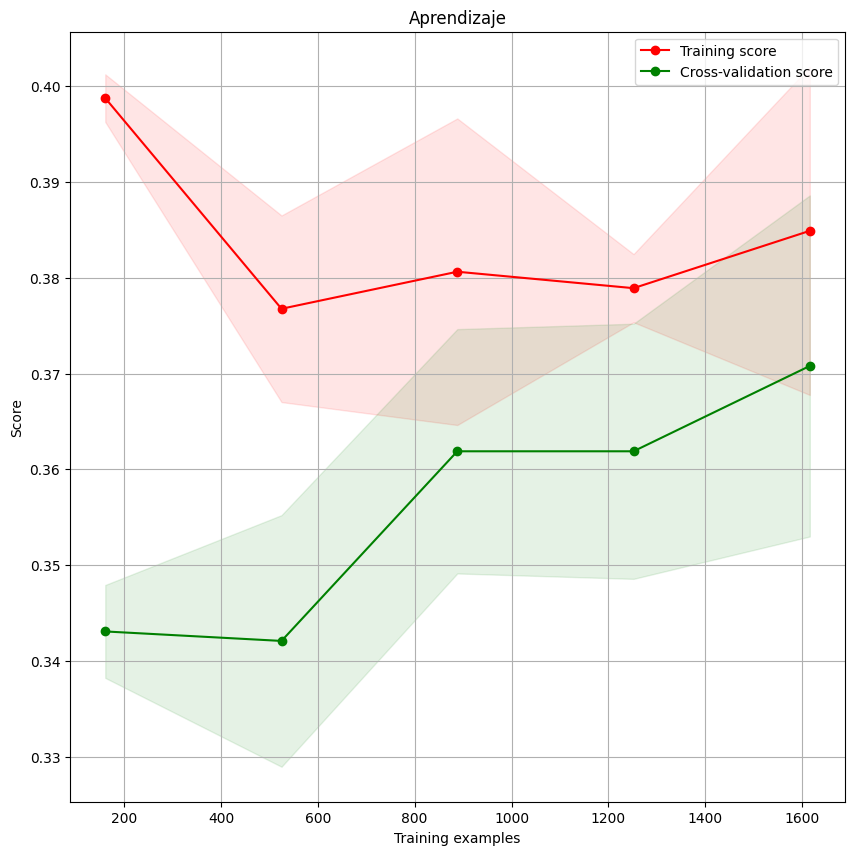

In [ ]:
#Matriz de confusión sujetos de entrenamiento
mc_train = confusion_matrix(y_train,predict_train)
plot_confusion_matrix(mc_train, classes=target_names,
                      title='Confusion matrix train')
#Se genera la curva de aprendizaje
plot_learning_curve(estimator=mlp_sib,
                    X=X_train,
                    y=y_train,
                    title='Aprendizaje')
plt.show()

              precision    recall  f1-score   support

 Crepitancia       0.44      0.28      0.34       303
       Sanos       0.38      0.79      0.51       291
  Sibilancia       0.48      0.11      0.17       272

    accuracy                           0.40       866
   macro avg       0.43      0.39      0.34       866
weighted avg       0.43      0.40      0.35       866

Confusion matrix, without normalization
[[ 86 197  20]
 [ 50 230  11]
 [ 61 182  29]]


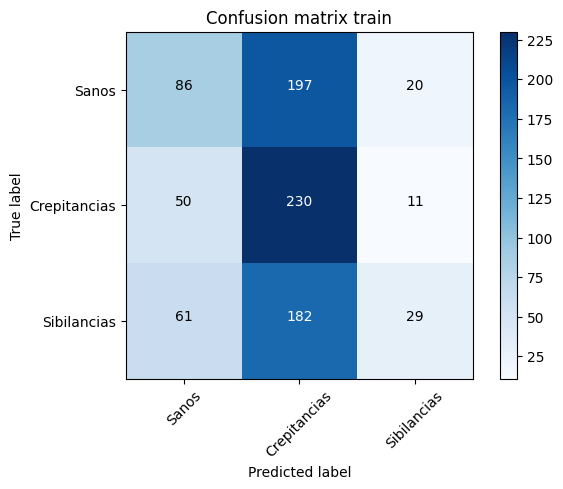

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

 Crepitancia       0.00      0.00      0.00       303
       Sanos       0.34      0.99      0.50       291
  Sibilancia       0.46      0.02      0.04       272

    accuracy                           0.34       866
   macro avg       0.27      0.34      0.18       866
weighted avg       0.26      0.34      0.18       866

Confusion matrix, without normalization
[[  0 299   4]
 [  0 288   3]
 [  0 266   6]]


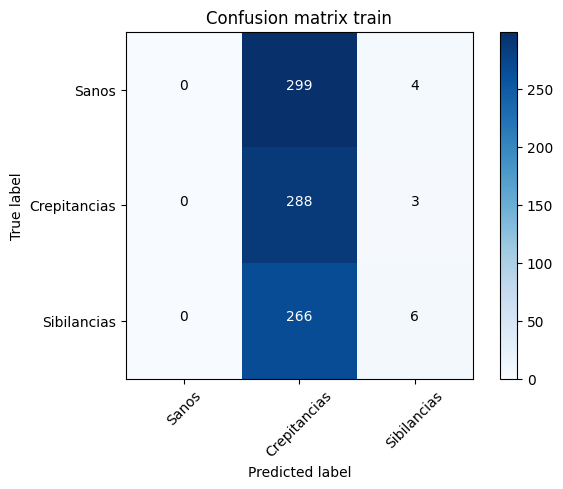

              precision    recall  f1-score   support

 Crepitancia       0.42      0.28      0.33       303
       Sanos       0.36      0.73      0.48       291
  Sibilancia       0.44      0.13      0.20       272

    accuracy                           0.38       866
   macro avg       0.41      0.38      0.34       866
weighted avg       0.41      0.38      0.34       866

Confusion matrix, without normalization
[[ 84 192  27]
 [ 61 212  18]
 [ 56 181  35]]


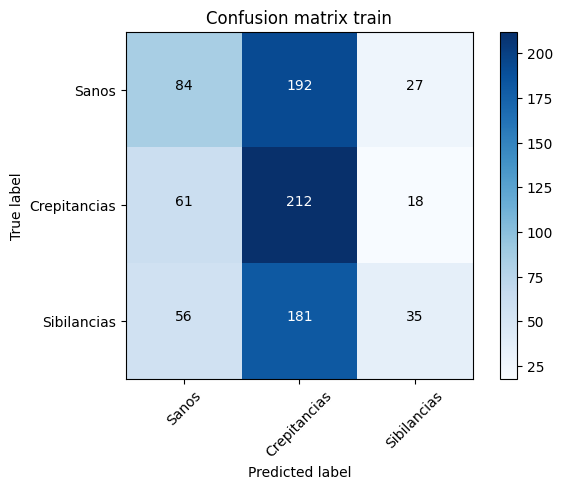

              precision    recall  f1-score   support

 Crepitancia       0.35      0.96      0.51       303
       Sanos       0.20      0.00      0.01       291
  Sibilancia       0.42      0.06      0.10       272

    accuracy                           0.35       866
   macro avg       0.32      0.34      0.21       866
weighted avg       0.32      0.35      0.21       866

Confusion matrix, without normalization
[[290   0  13]
 [282   1   8]
 [253   4  15]]


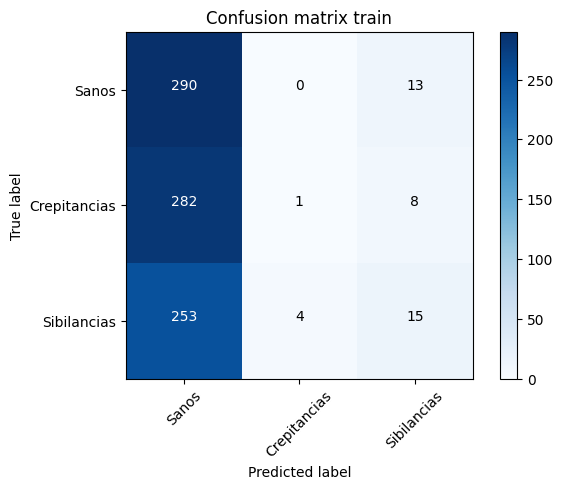

              precision    recall  f1-score   support

 Crepitancia       0.43      0.20      0.28       303
       Sanos       0.37      0.82      0.51       291
  Sibilancia       0.46      0.13      0.21       272

    accuracy                           0.39       866
   macro avg       0.42      0.39      0.33       866
weighted avg       0.42      0.39      0.33       866

Confusion matrix, without normalization
[[ 62 213  28]
 [ 38 239  14]
 [ 43 193  36]]


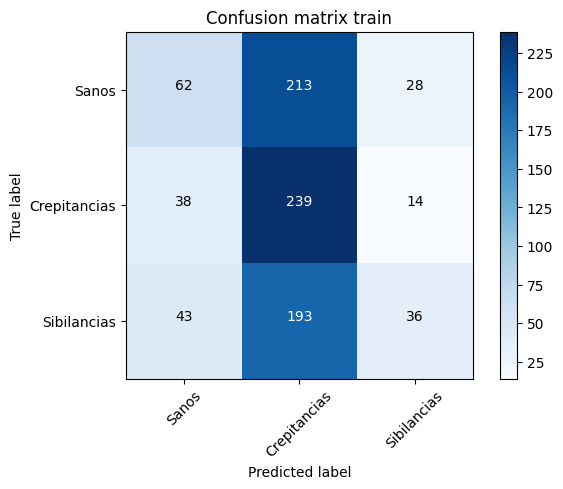

In [ ]:
# Proceso de k-folds
k_folds = KFold(5, random_state=1, shuffle = True)

scores_valid = np.zeros(10)

for pos, (train, test) in enumerate(k_folds.split( X_train, y_train)):
  #Se entrenan los datos y se establece el y predicho
  clf_2.fit(X_train[train], y_train[train])
  y_pred= clf_2.predict(X_test)
  #Se establecen las metricas de evaluación
  print(classification_report(y_test, y_pred))
  scores_valid[pos] = clf_2.score(X_test,y_test)

  mc_test_2 = confusion_matrix(y_test,y_pred)
  plot_confusion_matrix(mc_test_2, classes=target_names,
                      title='Confusion matrix train')
  plt.show()

# 2 arquitectura


In [ ]:
clf_2 = MLPClassifier((100,100,100,100), #Tamaño de la red
                      max_iter=10000, #Número de iteraciones
                      activation='relu', # Función de activación
                      solver='adam', # optimizador de función de perdida
                      learning_rate='adaptive', # Cambios en la tasa de aprendizaje
                      random_state=1,
                      early_stopping=True) #Evitar sobre entrenamiento en la convergencia del optimizador

In [ ]:
#Entrenamiento del modelo y predicciones
clf_2.fit(X_train, y_train)

predict_train_3_c = clf_2.predict(X_train)
predict_test_3_c = clf_2.predict(X_test)
#Metricas
target_names = ['Sanos','Crepitancias','sibilancias']
print(classification_report(y_train,predict_train_3_c,target_names=target_names))
print(classification_report(y_test,predict_test_3_c,target_names=target_names))

              precision    recall  f1-score   support

       Sanos       0.38      0.48      0.43       697
Crepitancias       0.36      0.51      0.42       709
 sibilancias       0.52      0.13      0.21       614

    accuracy                           0.38      2020
   macro avg       0.42      0.37      0.35      2020
weighted avg       0.42      0.38      0.36      2020

              precision    recall  f1-score   support

       Sanos       0.41      0.55      0.47       303
Crepitancias       0.38      0.49      0.43       291
 sibilancias       0.43      0.14      0.21       272

    accuracy                           0.40       866
   macro avg       0.41      0.39      0.37       866
weighted avg       0.41      0.40      0.38       866



Confusion matrix, without normalization
[[125 159  19]
 [ 68 207  16]
 [ 96 143  33]]
Confusion matrix, without normalization
[[291 377  29]
 [167 483  59]
 [180 348  86]]


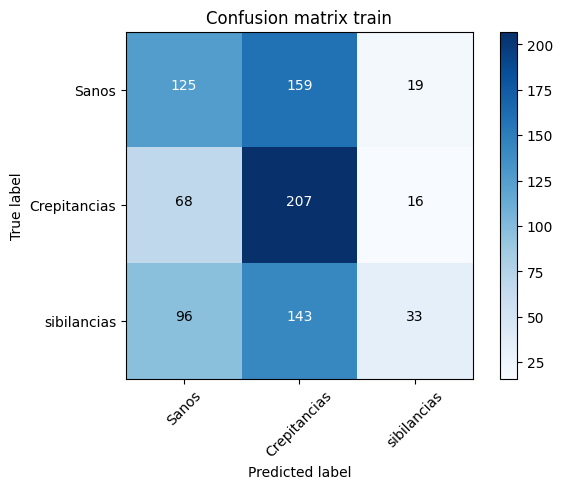

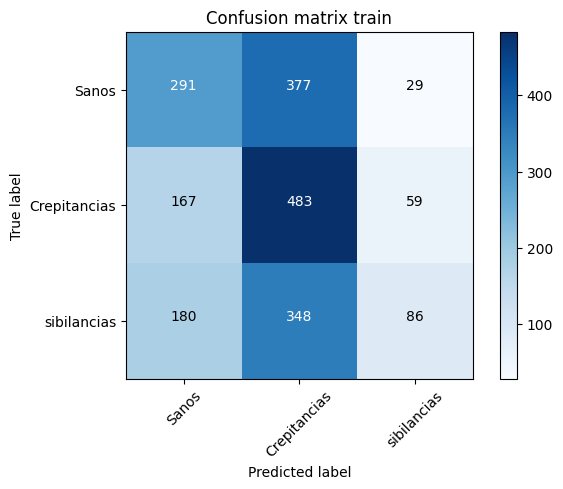

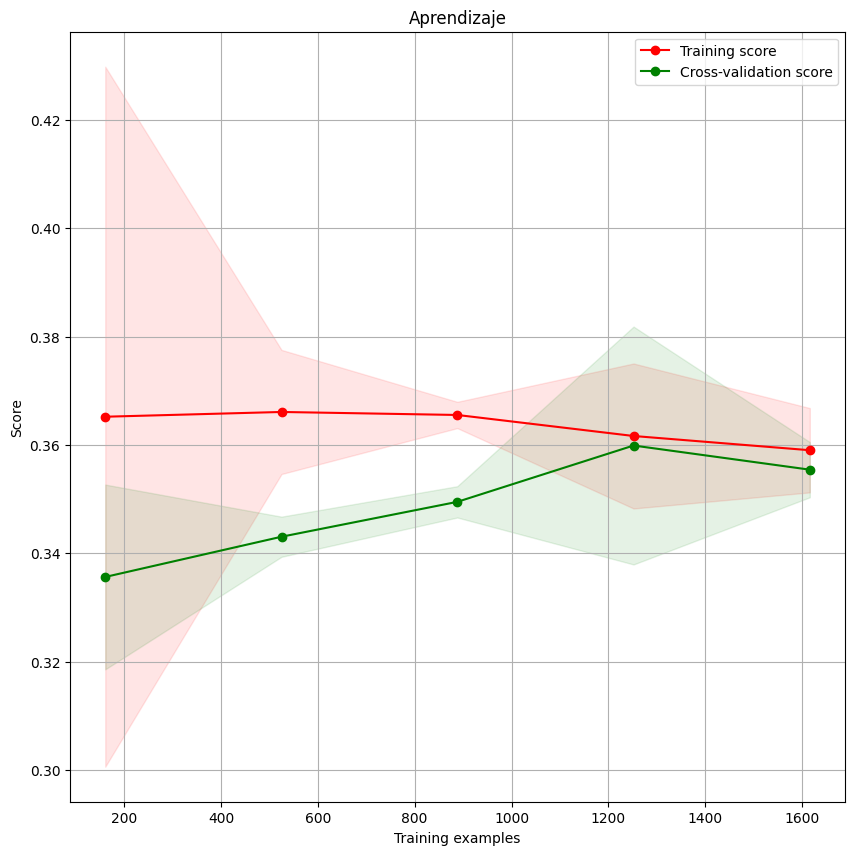

In [ ]:
#Matriz de confusión sujetos de prueba
mc_test = confusion_matrix(y_test,predict_test)
plot_confusion_matrix(mc_test, classes=target_names,
                      title='Confusion matrix train')
#Matriz de confusión sujetos de entrenamiento
mc_train = confusion_matrix(y_train,predict_train)
plot_confusion_matrix(mc_train, classes=target_names,
                      title='Confusion matrix train')
#Se genera la curva de aprendizaje
plot_learning_curve(estimator=clf_2,
                    X=X_train,
                    y=y_train,
                    title='Aprendizaje')
plt.show()

              precision    recall  f1-score   support

 Crepitancia       0.44      0.28      0.34       303
       Sanos       0.38      0.79      0.51       291
  Sibilancia       0.48      0.11      0.17       272

    accuracy                           0.40       866
   macro avg       0.43      0.39      0.34       866
weighted avg       0.43      0.40      0.35       866

Confusion matrix, without normalization
[[ 86 197  20]
 [ 50 230  11]
 [ 61 182  29]]


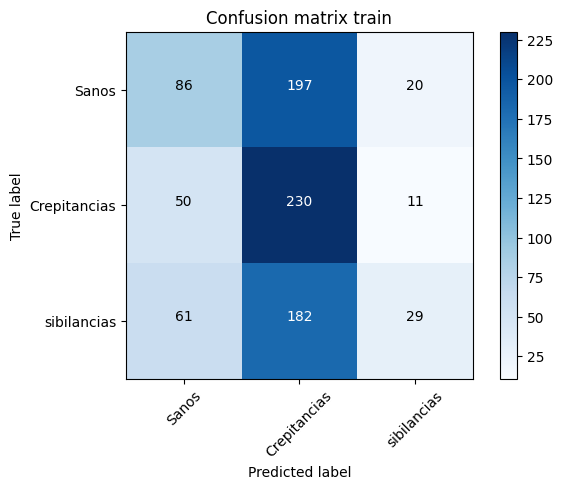

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

 Crepitancia       0.00      0.00      0.00       303
       Sanos       0.34      0.99      0.50       291
  Sibilancia       0.46      0.02      0.04       272

    accuracy                           0.34       866
   macro avg       0.27      0.34      0.18       866
weighted avg       0.26      0.34      0.18       866

Confusion matrix, without normalization
[[  0 299   4]
 [  0 288   3]
 [  0 266   6]]


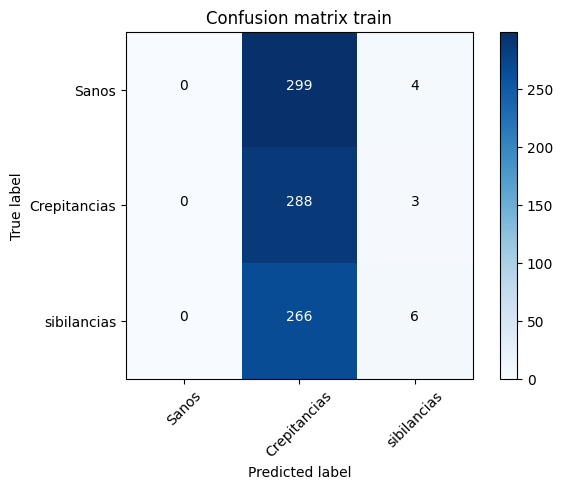

              precision    recall  f1-score   support

 Crepitancia       0.42      0.28      0.33       303
       Sanos       0.36      0.73      0.48       291
  Sibilancia       0.44      0.13      0.20       272

    accuracy                           0.38       866
   macro avg       0.41      0.38      0.34       866
weighted avg       0.41      0.38      0.34       866

Confusion matrix, without normalization
[[ 84 192  27]
 [ 61 212  18]
 [ 56 181  35]]


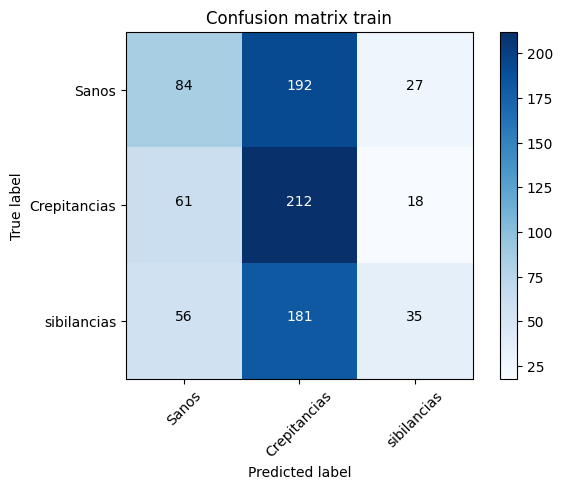

              precision    recall  f1-score   support

 Crepitancia       0.35      0.96      0.51       303
       Sanos       0.20      0.00      0.01       291
  Sibilancia       0.42      0.06      0.10       272

    accuracy                           0.35       866
   macro avg       0.32      0.34      0.21       866
weighted avg       0.32      0.35      0.21       866

Confusion matrix, without normalization
[[290   0  13]
 [282   1   8]
 [253   4  15]]


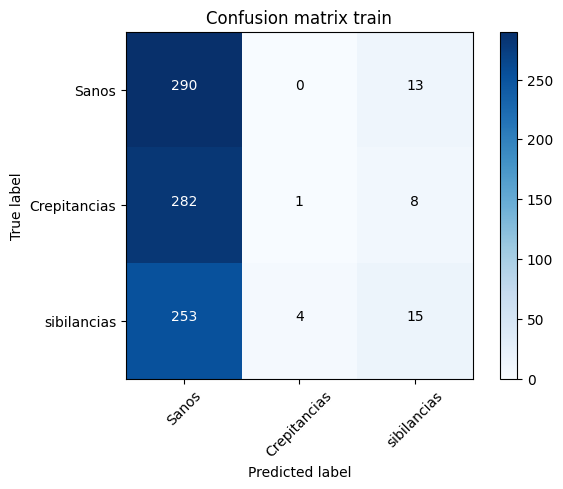

              precision    recall  f1-score   support

 Crepitancia       0.43      0.20      0.28       303
       Sanos       0.37      0.82      0.51       291
  Sibilancia       0.46      0.13      0.21       272

    accuracy                           0.39       866
   macro avg       0.42      0.39      0.33       866
weighted avg       0.42      0.39      0.33       866

Confusion matrix, without normalization
[[ 62 213  28]
 [ 38 239  14]
 [ 43 193  36]]


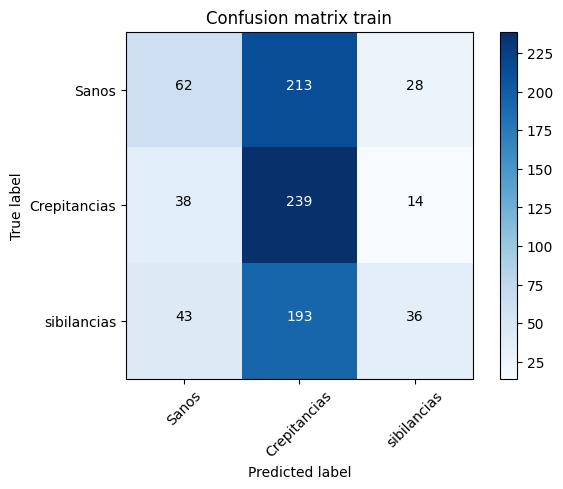

In [ ]:
# Proceso de k-folds
k_folds = KFold(5, random_state=1, shuffle = True)

scores_valid = np.zeros(10)

for pos, (train, test) in enumerate(k_folds.split( X_train, y_train)):
  #Se entrenan los datos y se establece el y predicho
  clf_2.fit(X_train[train], y_train[train])
  y_pred_crep = clf_2.predict(X_test)
  #Se establecen las metricas de evaluación
  print(classification_report(y_test, y_pred_crep))
  scores_valid[pos] = clf_2.score(X_test,y_test)

  mc_test_2 = confusion_matrix(y_test,y_pred_crep)
  plot_confusion_matrix(mc_test_2, classes=target_names,
                      title='Confusion matrix train')
  plt.show()

#3 arquitectura

In [ ]:
clf_3 = MLPClassifier((100,100,100,100,100,100), #Tamaño de la red
                      max_iter=1000, #Número de iteraciones
                      activation='relu', # Función de activación
                      solver='sgd', # optimizador de función de perdida
                      learning_rate='adaptive', # Cambios en la tasa de aprendizaje
                      random_state=1,
                      early_stopping=True) #Evitar sobre entrenamiento en la convergencia del optimizador

In [ ]:
#Entrenamiento del modelo y predicciones
clf_3.fit(X_train, y_train)

predict_train_3_c = clf_3.predict(X_train)
predict_test_3_c = clf_3.predict(X_test)
#Metricas
target_names = ['Sanos', 'Crepitancias','sibilancias']
print(classification_report(y_train,predict_train_3_c,target_names=target_names))
print(classification_report(y_test,predict_test_3_c,target_names=target_names))

              precision    recall  f1-score   support

       Sanos       0.35      1.00      0.51       697
Crepitancias       0.00      0.00      0.00       709
 sibilancias       0.00      0.00      0.00       614

    accuracy                           0.35      2020
   macro avg       0.12      0.33      0.17      2020
weighted avg       0.12      0.35      0.18      2020

              precision    recall  f1-score   support

       Sanos       0.35      1.00      0.52       303
Crepitancias       0.00      0.00      0.00       291
 sibilancias       0.00      0.00      0.00       272

    accuracy                           0.35       866
   macro avg       0.12      0.33      0.17       866
weighted avg       0.12      0.35      0.18       866



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif

Confusion matrix, without normalization
[[125 159  19]
 [ 68 207  16]
 [ 96 143  33]]
Confusion matrix, without normalization
[[291 377  29]
 [167 483  59]
 [180 348  86]]


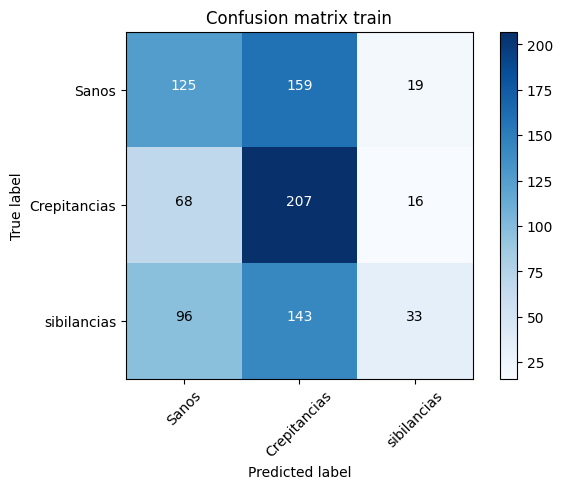

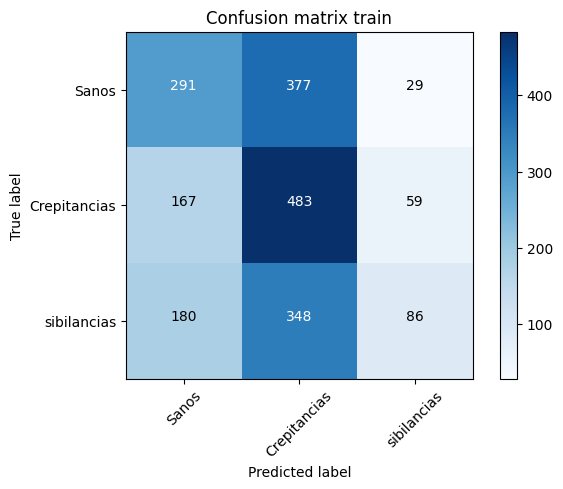

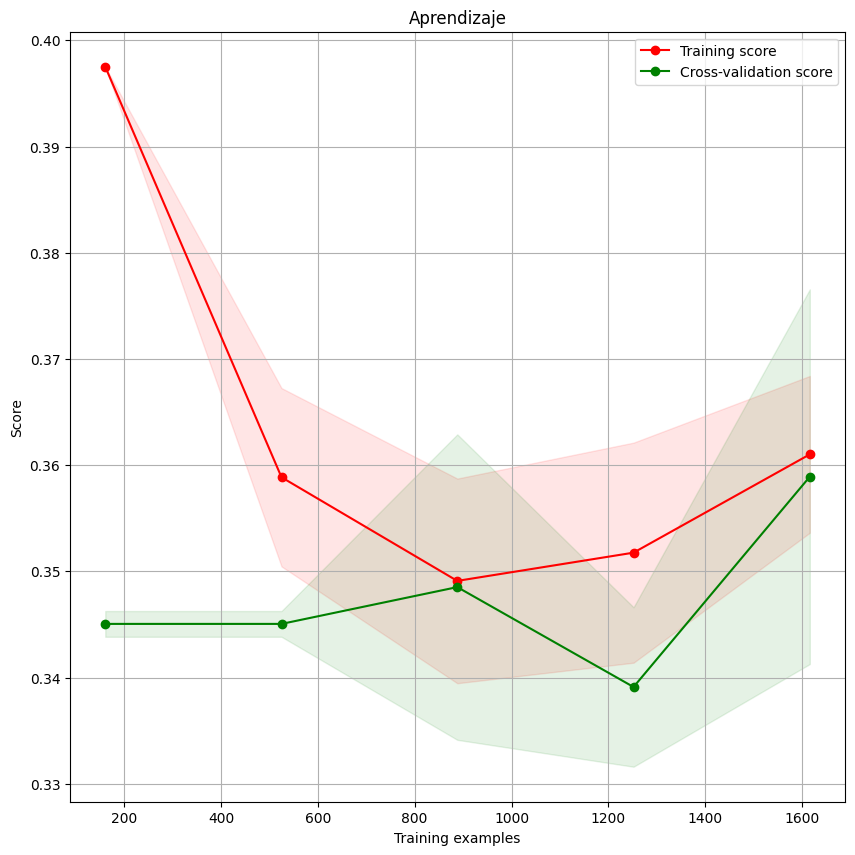

In [ ]:
#Matriz de confusión sujetos de prueba
mc_test = confusion_matrix(y_test,predict_test)
plot_confusion_matrix(mc_test, classes=target_names,
                      title='Confusion matrix train')
#Matriz de confusión sujetos de entrenamiento
mc_train = confusion_matrix(y_train,predict_train)
plot_confusion_matrix(mc_train, classes=target_names,
                      title='Confusion matrix train')
#Se genera la curva de aprendizaje
plot_learning_curve(estimator=clf_3,
                    X=X_train,
                    y=y_train,
                    title='Aprendizaje')
plt.show()

              precision    recall  f1-score   support

 Crepitancia       0.44      0.28      0.34       303
       Sanos       0.38      0.79      0.51       291
  Sibilancia       0.48      0.11      0.17       272

    accuracy                           0.40       866
   macro avg       0.43      0.39      0.34       866
weighted avg       0.43      0.40      0.35       866

Confusion matrix, without normalization
[[ 86 197  20]
 [ 50 230  11]
 [ 61 182  29]]


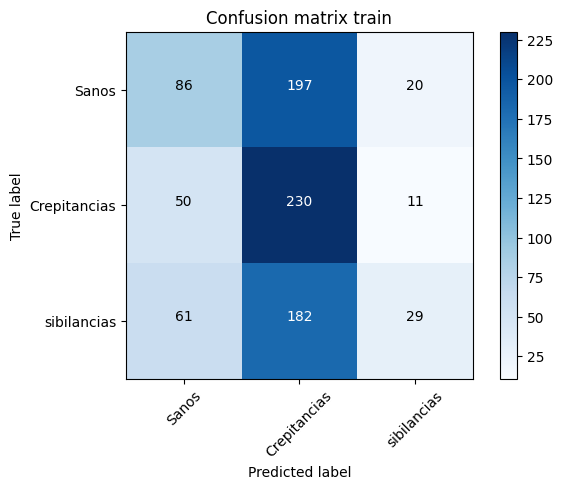

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

 Crepitancia       0.00      0.00      0.00       303
       Sanos       0.34      0.99      0.50       291
  Sibilancia       0.46      0.02      0.04       272

    accuracy                           0.34       866
   macro avg       0.27      0.34      0.18       866
weighted avg       0.26      0.34      0.18       866

Confusion matrix, without normalization
[[  0 299   4]
 [  0 288   3]
 [  0 266   6]]


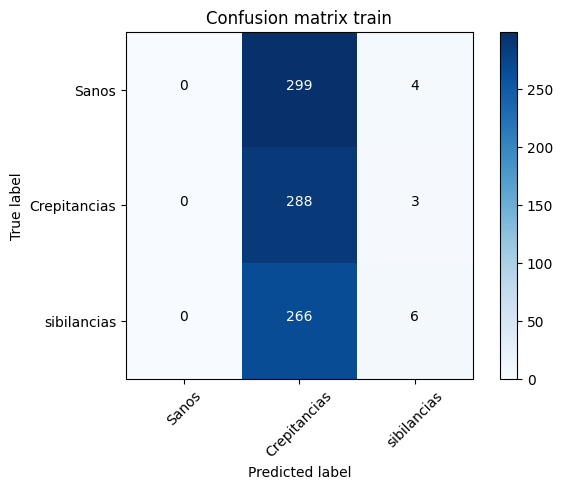

              precision    recall  f1-score   support

 Crepitancia       0.42      0.28      0.33       303
       Sanos       0.36      0.73      0.48       291
  Sibilancia       0.44      0.13      0.20       272

    accuracy                           0.38       866
   macro avg       0.41      0.38      0.34       866
weighted avg       0.41      0.38      0.34       866

Confusion matrix, without normalization
[[ 84 192  27]
 [ 61 212  18]
 [ 56 181  35]]


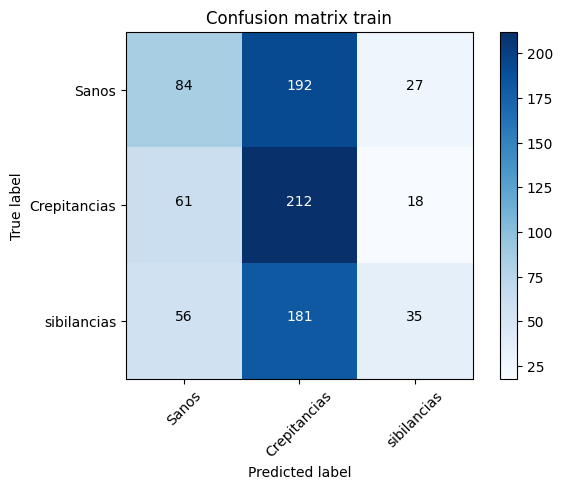

              precision    recall  f1-score   support

 Crepitancia       0.35      0.96      0.51       303
       Sanos       0.20      0.00      0.01       291
  Sibilancia       0.42      0.06      0.10       272

    accuracy                           0.35       866
   macro avg       0.32      0.34      0.21       866
weighted avg       0.32      0.35      0.21       866

Confusion matrix, without normalization
[[290   0  13]
 [282   1   8]
 [253   4  15]]


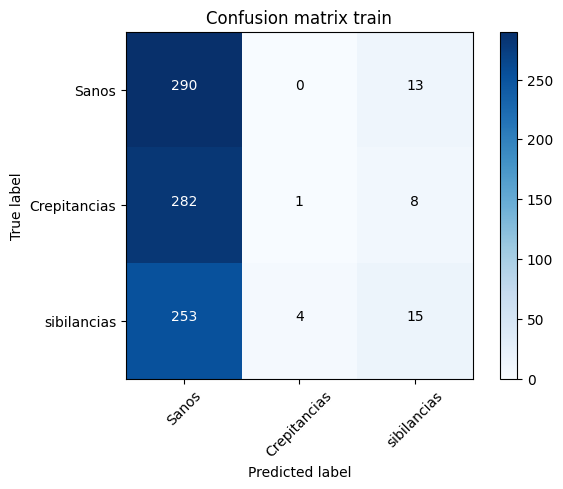

              precision    recall  f1-score   support

 Crepitancia       0.43      0.20      0.28       303
       Sanos       0.37      0.82      0.51       291
  Sibilancia       0.46      0.13      0.21       272

    accuracy                           0.39       866
   macro avg       0.42      0.39      0.33       866
weighted avg       0.42      0.39      0.33       866

Confusion matrix, without normalization
[[ 62 213  28]
 [ 38 239  14]
 [ 43 193  36]]


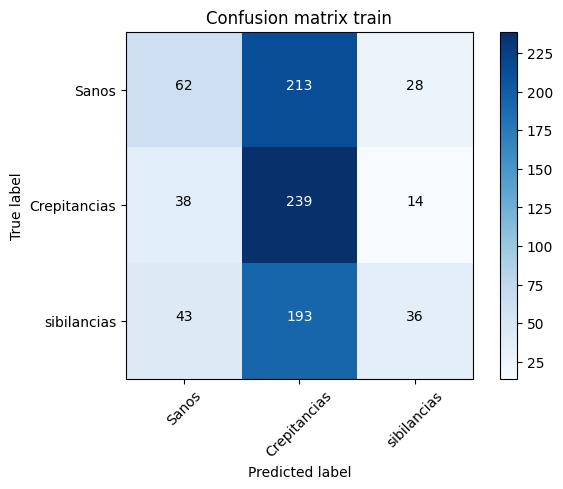

In [ ]:
# Proceso de k-folds
k_folds = KFold(5, random_state=1, shuffle = True)

scores_valid = np.zeros(10)

for pos, (train, test) in enumerate(k_folds.split( X_train, y_train)):
  #Se entrenan los datos y se establece el y predicho
  clf_2.fit(X_train[train], y_train[train])
  y_pred_crep = clf_2.predict(X_test)
  #Se establecen las metricas de evaluación
  print(classification_report(y_test, y_pred_crep))
  scores_valid[pos] = clf_2.score(X_test,y_test)

  mc_test_2 = confusion_matrix(y_test,y_pred_crep)
  plot_confusion_matrix(mc_test_2, classes=target_names,
                      title='Confusion matrix train')
  plt.show()

# KMeans

Silibancias vs Ausencia de ruidos

K-means es un algoritmo de clasificación no supervisada (clusterización) que agrupa objetos en k grupos basándose en sus características. En este caso agruparemos las caracteristicas en 2 grupos o clusteres (K=2), los cuales representaran los pacientes normales vs con silibancias

In [ ]:
#Se extraen del data set las caracteristicas que se utilizaran para realizar la red neuronal
predictors_ = (list(set(list(data_frame_final_.columns))-set(['Clasificación'])-set(['Posicion'])-set(['Número sujeto'])-set(['Nombre del archivo'])-set(['Raw signals'])-set(['Unnamed: 0'])-set(['Unnamed: 0.1'])-set(['genero'])-set(['edad'])-set(['Mediana'])))
print(predictors_)
#Se crea un data_frame que solo contenga los sujetos sanos y los sujetos con sibilancias
#sujetos con sibilancias
sibilancia = data_frame_final_.loc[:, 'Clasificación'] == 'Sibilancia'
df_sibilancias = data_frame_final_.loc[sibilancia]
#Sujetos sanos
sanos = data_frame_final_.loc[:, 'Clasificación'] == 'Sanos'
df_sanos = data_frame_final_.loc[sanos]

#Se concatenan los data frame de los sujetos sanos y los sujetos con sibilancia; es de resaltar que debido al desbalanceo de datos
# se establece un limite en la longitud de los datos de sujetos sanos, con el fin de que ambos grupos a analizar presenten una cantidad de datos
#que no sea tan diferentes entre si
# Ordena el DataFrame por la columna "Edades" de menor a mayor
df_edades_ordenadas = df_sanos.sort_values(by="edad")
y=pd.concat([df_edades_ordenadas[100:600],df_edades_ordenadas[2000:2500]])

sibilancias_final = pd.concat([df_sibilancias,y])
X = sibilancias_final[predictors_].values
k_means=KMeans(n_clusters=2)
k_means.fit(X)
centroides=k_means.cluster_centers_
etiquetas=k_means.labels_

['Varianza', 'ADPE', 'DPE']


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


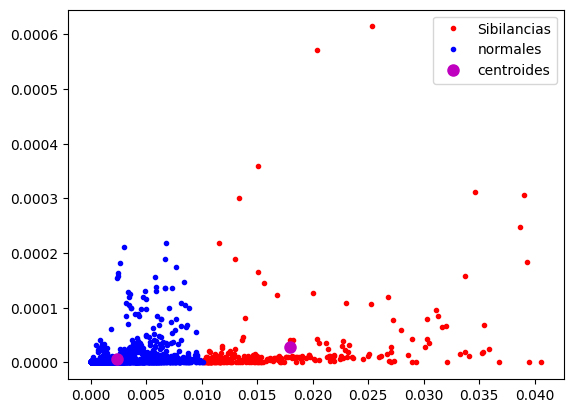

In [ ]:
plt.plot(X[etiquetas==0,0],X[etiquetas==0,1],'r.', label='Sibilancias')
plt.plot(X[etiquetas==1,0],X[etiquetas==1,1],'b.', label='normales')
plt.plot(centroides[:,0],centroides[:,1],'mo',markersize=8, label='centroides')
plt.legend(loc='best')
plt.show()

Crepitancias vs Ausencia de ruidos

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


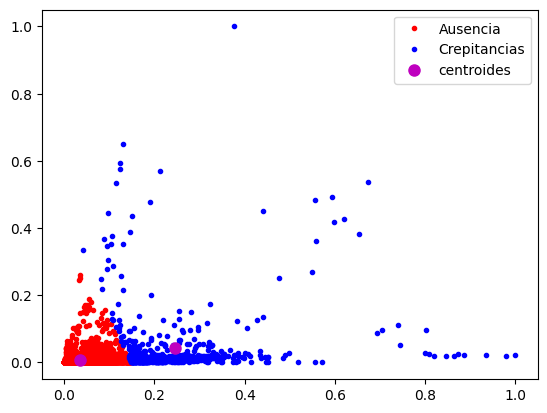

In [ ]:
X = crepitancia_final[predictors_].values
k_means=KMeans(n_clusters=2)
k_means.fit(X)
centroides=k_means.cluster_centers_
etiquetas=k_means.labels_
plt.plot(X[etiquetas==0,0],X[etiquetas==0,1],'r.', label='Ausencia')
plt.plot(X[etiquetas==1,0],X[etiquetas==1,1],'b.', label='Crepitancias')
plt.plot(centroides[:,0],centroides[:,1],'mo',markersize=8, label='centroides')
plt.legend(loc='best')
plt.show()

#SVM


In [ ]:
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score


In [ ]:
# Creación del modelo SVM lineal
# ==============================================================================
modelo = SVC(C = 100, kernel = 'linear', random_state=123)
modelo.fit(X_train, y_train)

SVC(C=100, kernel='linear', random_state=123)

In [ ]:
ypred = modelo.predict(X_test_crep)
score = modelo.score(X_train_crep, y_train_crep)
print("Score: ", score)

predict_train_3_c = modelo.predict(X_train_crep)
predict_test_3_c = modelo.predict(X_test_crep)
target_names = ['Sanos', 'Crepitancias']
print(classification_report(y_train_crep,predict_train_3_c , target_names=target_names))
print(classification_report(y_test_crep,predict_test_3_c,target_names=target_names))

Score:  0.5561748313288354
              precision    recall  f1-score   support

       Sanos       0.65      0.23      0.34      1688
Crepitancias       0.54      0.88      0.67      1721

    accuracy                           0.56      3409
   macro avg       0.59      0.55      0.50      3409
weighted avg       0.59      0.56      0.50      3409

              precision    recall  f1-score   support

       Sanos       0.66      0.23      0.34       682
Crepitancias       0.57      0.89      0.70       779

    accuracy                           0.59      1461
   macro avg       0.62      0.56      0.52      1461
weighted avg       0.61      0.59      0.53      1461



In [ ]:

predict_train_svc = modelo.predict(X_train_crep)
predict_test_svc = modelo.predict(X_test_crep)

Confusion matrix, without normalization
[[159 523]
 [ 82 697]]
Confusion matrix, without normalization
[[ 383 1305]
 [ 208 1513]]


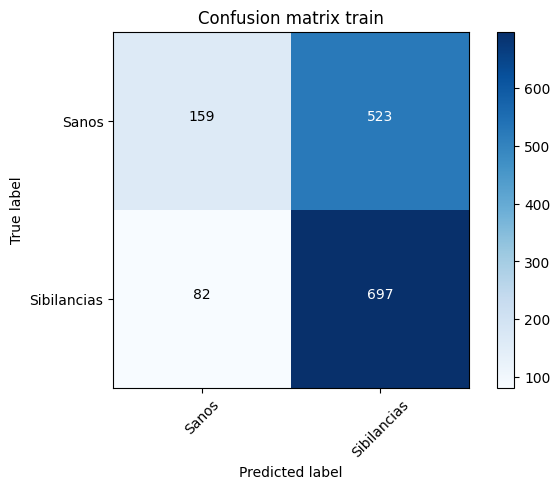

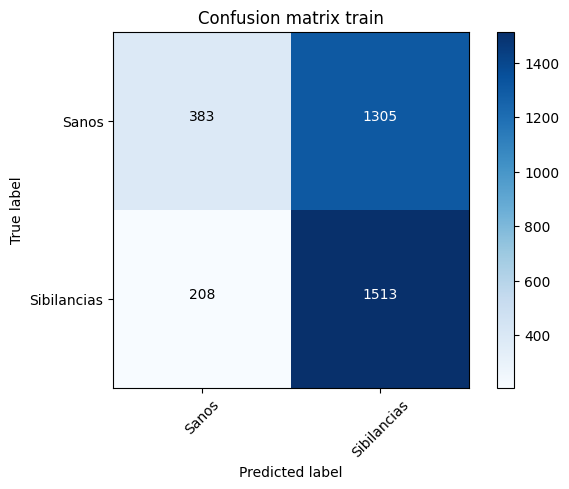

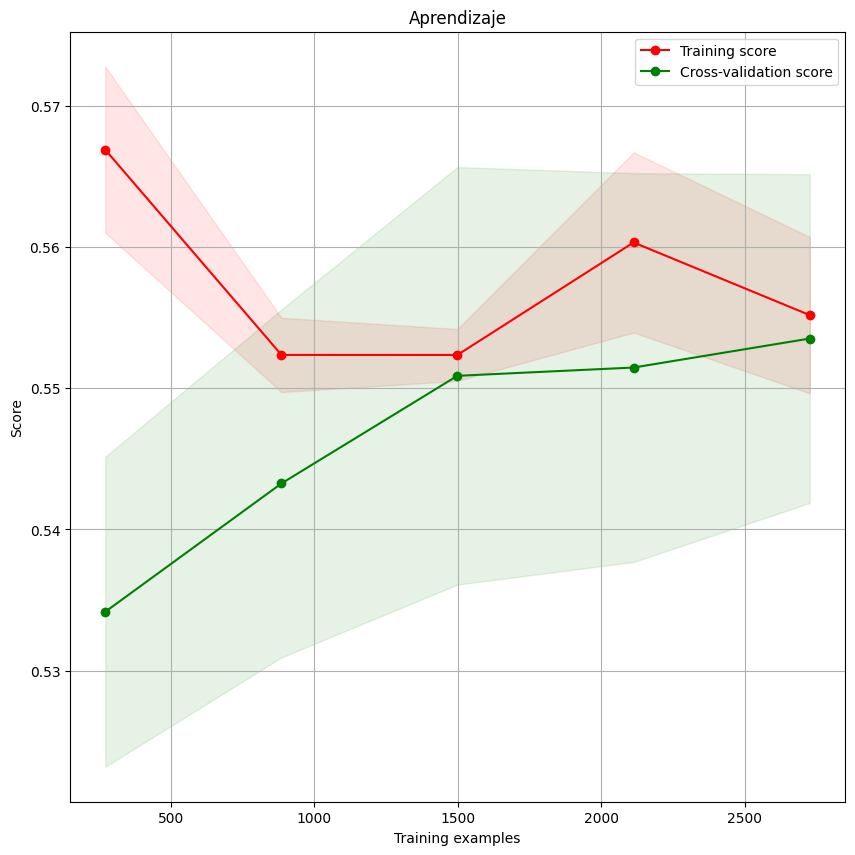

In [ ]:
target_names = ['Sanos', 'Sibilancias']
#Matriz de confusión sujetos de prueba
mc_test = confusion_matrix(y_test_crep,predict_test_svc)
plot_confusion_matrix(mc_test, classes=target_names,
                      title='Confusion matrix train')
#Matriz de confusión sujetos de entrenamiento
mc_train = confusion_matrix(y_train_crep,predict_train_svc)
plot_confusion_matrix(mc_train, classes=target_names,
                      title='Confusion matrix train')
#Se genera la curva de aprendizaje
plot_learning_curve(estimator=modelo,
                    X=X_train_crep,
                    y=y_train_crep,
                    title='Aprendizaje')
plt.show()

SVM radial


Se repite el ajuste del modelo, esta vez empleando un kernel radial y utilizando validación cruzada para identificar el valor óptimo de penalización

In [ ]:
modelo2= SVC(C=100, kernel= "rbf", gamma='scale')
modelo2.fit(X_train_crep, y_train_crep)


SVC(C=100)

In [ ]:
ypred = modelo2.predict(X_test_crep)
score = modelo2.score(X_train_crep, y_train_crep)
print("Score: ", score)

Score:  0.5872689938398358
